In [1]:
#-*- coding: utf-8 -*-最新
import pandas as pd
import matplotlib.pyplot as plt
from ase.io import Trajectory
from ase import units
import sys
import re
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import interpolate
import glob
from pathlib import Path
from ase.neighborlist import build_neighbor_list, natural_cutoffs # (★追加) H2O識別用

# --- 基本設定 ---
# !!! このパスは、.dat と .traj ファイルが保存されている実際のディレクトリに変更してください !!!
TENSILE_DIR = "/home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/tensile01"
TENSILE_TEMPERATURE = 300.0

# --- 出力ディレクトリの作成 ---
OUTPUT_BASE_PATH = Path("/home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output")
OUTPUT_FIGURE_DIR = OUTPUT_BASE_PATH / "stress_strain_curves"
OUTPUT_BASE_PATH.mkdir(exist_ok=True)
OUTPUT_FIGURE_DIR.mkdir(exist_ok=True)

# ==============================================================================
# 応力ひずみ解析モジュール (.dat ファイルベース)
# ==============================================================================

def calculate_yield_stress(strain_array, stress_array_mpa, youngs_modulus_mpa):
    # (変更なし)
    if np.isnan(youngs_modulus_mpa) or youngs_modulus_mpa == 0:
        return np.nan, np.nan
    offset_line_stress = youngs_modulus_mpa * (strain_array - 0.002)
    stress_diff = stress_array_mpa - offset_line_stress
    sign_changes = np.where(np.diff(np.sign(stress_diff)))[0]
    for idx in sign_changes:
        if strain_array[idx] > 0.002 and stress_array_mpa[idx] > 0:
            x1, x2 = strain_array[idx], strain_array[idx+1]
            y1_data, y2_data = stress_array_mpa[idx], stress_array_mpa[idx+1]
            y1_off, y2_off = offset_line_stress[idx], offset_line_stress[idx+1]
            try:
                a1 = (y2_data - y1_data) / (x2 - x1)
                b1 = y1_data - a1 * x1
                a2 = youngs_modulus_mpa
                b2 = -0.002 * youngs_modulus_mpa
                if (a1 - a2) == 0: continue
                intersection_strain = (b2 - b1) / (a1 - a2)
                intersection_stress = a1 * intersection_strain + b1
                if x1 <= intersection_strain <= x2:
                    return intersection_stress, intersection_strain
            except ZeroDivisionError:
                continue
    return np.nan, np.nan

def analyze_stress_strain_from_dat(dat_file_path):
    # (変更なし)
    results = {
        'youngs_modulus_GPa': np.nan,
        'tensile_strength_GPa': np.nan,
        'yield_stress_GPa_0.2offset': np.nan,
        'intersection_strain': np.nan,
        'strain_at_zero_stress': 0.0,
        'stress_at_zero_stress_GPa': 0.0
    }
    try:
        data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,
                           names=['Step', 'Strain', 'Stress(GPa)', 'YoungMod(GPa)', 'Status', 'Time(ps)', 'InterfaceNotes'])
        if data.empty:
            return results, None
        strain = data['Strain'].values
        stress_gpa = data['Stress(GPa)'].values
        zero_stress_index = np.abs(stress_gpa).argmin()
        strain_offset = strain[zero_stress_index]
        stress_offset_gpa = stress_gpa[zero_stress_index]
        results['strain_at_zero_stress'] = strain_offset
        results['stress_at_zero_stress_GPa'] = stress_offset_gpa
        strain_analysis_raw = strain[:]
        stress_gpa_analysis_raw = stress_gpa[:]
        strain_analysis = strain_analysis_raw - strain_offset
        stress_gpa_analysis = stress_gpa_analysis_raw - stress_offset_gpa
        stress_mpa_analysis = stress_gpa_analysis * 1000
        if strain_analysis.size < 2:
            return results, None
        linear_range_mask = (strain_analysis >= 0.0) & (strain_analysis <= 0.05)
        if np.sum(linear_range_mask) > 1:
            X = strain_analysis[linear_range_mask].reshape(-1, 1)
            y = stress_mpa_analysis[linear_range_mask]
            linear_model = LinearRegression(fit_intercept=False).fit(X, y)
            youngs_modulus_mpa = linear_model.coef_[0]
            if youngs_modulus_mpa > 0:
                results['youngs_modulus_GPa'] = youngs_modulus_mpa / 1000
            else:
                youngs_modulus_mpa = np.nan
        else:
            youngs_modulus_mpa = np.nan
        results['tensile_strength_GPa'] = stress_gpa_analysis_raw.max()
        yield_stress_mpa, intersection_strain_relative = calculate_yield_stress(strain_analysis, stress_mpa_analysis, youngs_modulus_mpa)
        if not np.isnan(yield_stress_mpa):
            results['yield_stress_GPa_0.2offset'] = (yield_stress_mpa + stress_offset_gpa * 1000) / 1000
            results['intersection_strain'] = intersection_strain_relative + strain_offset
        plot_data = pd.DataFrame({'strain': strain, 'stress': stress_gpa * 1000})
        return results, plot_data
    except Exception as e:
        print(f"  - .datファイルの解析中にエラー: {e}")
        return results, None

# ==============================================================================
# 破断界面解析モジュール
# ==============================================================================

def find_fracture_step(traj, void_size=3.0, search_region_ratio=2.0/3.0):
    # (変更なし)
    if not traj:
        return None, -1, -1
    for i, atoms in enumerate(traj):
        cell = atoms.get_cell()
        lz = cell[2, 2]
        z_max_search = lz * search_region_ratio
        positions = atoms.get_positions()
        z_coords = positions[:, 2]
        in_region_mask = (z_coords >= 10.0) & (z_coords < z_max_search)
        region_z_coords = z_coords[in_region_mask]
        if len(region_z_coords) < 2:
            continue
        sorted_z = np.sort(region_z_coords)
        gaps = sorted_z[1:] - sorted_z[:-1]
        if np.any(gaps >= void_size):
            max_gap_index = np.argmax(gaps)
            fracture_z = (sorted_z[max_gap_index] + sorted_z[max_gap_index + 1]) / 2.0
            return atoms, i, fracture_z
    return None, -1, -1

# (★変更) H2O識別機能、Al, Hのカウントを追加
def analyze_distribution_at_fracture(atoms, z_boundary):
    """
    破断瞬間の原子スナップショットを基に、境界面上下の原子分布を解析する。
    H2Oを識別し、格子酸素(O)、水(H2O)、PVDFのH(H)を分けてカウントする。
    """
    symbols = np.array(atoms.get_chemical_symbols())
    positions = atoms.get_positions()

    # --- H2O分子の識別 ---
    h2o_oxygen_indices = set()
    h2o_hydrogen_indices = set()
    if 'O' in symbols and 'H' in symbols:
        try:
            cutoffs = natural_cutoffs(atoms)
            nl = build_neighbor_list(atoms, cutoffs=cutoffs, self_interaction=False)
            o_indices = np.where(symbols == 'O')[0]
            h_indices_set = set(np.where(symbols == 'H')[0])
            for o_idx in o_indices:
                neighbors_indices, _ = nl.get_neighbors(o_idx)
                bonded_h_atoms = [n_idx for n_idx in neighbors_indices if n_idx in h_indices_set]
                if len(bonded_h_atoms) == 2:
                    h2o_oxygen_indices.add(o_idx)
                    h2o_hydrogen_indices.update(bonded_h_atoms)
        except Exception as e:
            print(f"  [警告] H2O分子の識別に失敗 (破断時): {e}")
    
    # --- 全元素のカウント用辞書を初期化 ---
    # (★変更) Al, H, H2O を追加
    elements_to_count = ["Al", "O", "C", "F", "H", "H2O", "Li", "Mn", "Co", "Ni"]
    results = {elem: {'upper': 0, 'lower': 0, 'total': 0} for elem in elements_to_count}

    # --- カウントループ ---
    for i, symbol in enumerate(symbols):
        elem_key = None # カウント対象のキー

        if symbol == 'O':
            elem_key = 'H2O' if i in h2o_oxygen_indices else 'O'
        elif symbol == 'H':
            if i not in h2o_hydrogen_indices:
                elem_key = 'H' # H2O由来でなければ 'H' (PVDFなど)
        elif symbol in results:
            elem_key = symbol # Al, C, F, Li, Mn, Co, Ni
        
        if elem_key:
            results[elem_key]['total'] += 1
            if positions[i, 2] > z_boundary:
                results[elem_key]['upper'] += 1
            else:
                results[elem_key]['lower'] += 1
                
    return results

# (★追加) プログラム2から analyze_initial_distribution 関数をコピー
def analyze_initial_distribution(initial_atoms):
    """
    T=0 のスナップショットを基に、初期の界面位置とF, O, H, H2O原子の分布を解析する。
    C原子（基板=下）とAl原子/NMC原子（材料=上）の位置から界面を推定する。
    H2O分子を近接原子リストで識別する。
    """
    positions = initial_atoms.get_positions()
    symbols = np.array(initial_atoms.get_chemical_symbols())
    
    # --- 1. 界面の特定 ---
    c_atoms_z = positions[np.isin(symbols, ['C']), 2]
    al_atoms_z = positions[np.isin(symbols, ['Al']), 2]
    nmc_elements = ['Li', 'Mn', 'Co', 'Ni']
    nmc_mask = np.isin(symbols, nmc_elements)
    
    z_boundary_initial = np.nan
    
    if c_atoms_z.size > 0 and al_atoms_z.size > 0:
        z_max_c = c_atoms_z.max()
        z_min_al = al_atoms_z.min()
        z_boundary_initial = (z_max_c + z_min_al) / 2.0
    elif c_atoms_z.size > 0 and np.any(nmc_mask):
        nmc_atoms_z = positions[nmc_mask, 2]
        z_max_c = c_atoms_z.max()
        z_min_nmc = nmc_atoms_z.min()
        z_boundary_initial = (z_max_c + z_min_nmc) / 2.0
    else:
        print("  [警告] 初期界面の特定に失敗 (C原子、およびAl/NMC原子のいずれかが見つかりません)。")
        return {}, np.nan

    # --- 2. H2O分子の識別 ---
    h2o_oxygen_indices = set()
    h2o_hydrogen_indices = set()
    if 'O' in symbols and 'H' in symbols:
        try:
            cutoffs = natural_cutoffs(initial_atoms)
            nl = build_neighbor_list(initial_atoms, cutoffs=cutoffs, self_interaction=False)
            o_indices = np.where(symbols == 'O')[0]
            h_indices_set = set(np.where(symbols == 'H')[0])
            for o_idx in o_indices:
                neighbors_indices, _ = nl.get_neighbors(o_idx)
                bonded_h_atoms = [n_idx for n_idx in neighbors_indices if n_idx in h_indices_set]
                if len(bonded_h_atoms) == 2:
                    h2o_oxygen_indices.add(o_idx)
                    h2o_hydrogen_indices.update(bonded_h_atoms)
        except Exception as e:
            print(f"  [警告] H2O分子の識別に失敗 (T=0): {e}")

    # --- 3. 分布カウント ---
    initial_counts = {
        'F_upper': 0, 'F_lower': 0, 'F_total': 0,
        'O_upper': 0, 'O_lower': 0, 'O_total': 0,   # 格子酸素
        'H_upper': 0, 'H_lower': 0, 'H_total': 0,   # PVDF等のH
        'H2O_upper': 0, 'H2O_lower': 0, 'H2O_total': 0 # H2O
    }

    for i, symbol in enumerate(symbols):
        elem_key = None
        
        if symbol == 'F':
            elem_key = 'F'
        elif symbol == 'O':
            elem_key = 'H2O' if i in h2o_oxygen_indices else 'O'
        elif symbol == 'H':
            if i not in h2o_hydrogen_indices:
                elem_key = 'H'
        
        if elem_key:
            initial_counts[f'{elem_key}_total'] += 1
            if positions[i, 2] > z_boundary_initial:
                initial_counts[f'{elem_key}_upper'] += 1
            else:
                initial_counts[f'{elem_key}_lower'] += 1
                
    return initial_counts, z_boundary_initial

# ==============================================================================
# ヘルパー関数 (Miller指数読み取り, プロット, スコアリング)
# ==============================================================================

def get_miller_index_from_summary(summary_file_path):
    # (変更なし)
    if not os.path.exists(summary_file_path):
        return "N/A"
    try:
        with open(summary_file_path, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip().startswith("NMC Miller指数:"):
                    return line.split(':', 1)[1].strip()
    except Exception as e:
        print(f"  [警告] summary.txtの読み取り中にエラー: {e}")
        return "Error"
    return "Not Found"

def plot_stress_strain_curve(data, analysis_results, file_identifier, output_dir):
    # (変更なし)
    if data is None or data.empty: return
    fig_path = os.path.join(output_dir, f"{file_identifier}_ss_curve.png")
    plt.figure(figsize=(10, 7))
    stress_gpa = data['stress'] / 1000
    strain = data['strain']
    plt.plot(strain, stress_gpa, label='Stress-Strain Curve', alpha=0.7)
    strain_at_zero = analysis_results.get('strain_at_zero_stress', 0.0)
    stress_at_zero_gpa = analysis_results.get('stress_at_zero_stress_GPa', 0.0)
    youngs_modulus_gpa = analysis_results.get('youngs_modulus_GPa', np.nan)
    if not np.isnan(youngs_modulus_gpa):
        fit_strain_end = strain_at_zero + 0.05
        fit_strain_end = min(fit_strain_end, strain.max())
        linear_range_strain = np.linspace(strain_at_zero, fit_strain_end, 10)
        linear_fit_gpa = youngs_modulus_gpa * (linear_range_strain - strain_at_zero) + stress_at_zero_gpa
        plt.plot(linear_range_strain, linear_fit_gpa, 'r-', linewidth=2, 
                 label=f'Young\'s Modulus Fit ({youngs_modulus_gpa:.1f} GPa)')
    yield_stress_gpa = analysis_results.get('yield_stress_GPa_0.2offset', np.nan)
    intersection_strain = analysis_results.get('intersection_strain', np.nan)
    if not np.isnan(yield_stress_gpa) and not np.isnan(intersection_strain) and not np.isnan(youngs_modulus_gpa):
        offset_start_strain = strain_at_zero + 0.002
        offset_strain_range = np.linspace(offset_start_strain, strain.max(), 100)
        offset_line_gpa = youngs_modulus_gpa * (offset_strain_range - offset_start_strain) + stress_at_zero_gpa
        plt.plot(offset_strain_range, offset_line_gpa, 'g--', label='0.2% Offset Line')
        plt.scatter([intersection_strain], [yield_stress_gpa], color='orange', s=150, 
                    marker='*', zorder=5, label=f'Yield Point ({yield_stress_gpa:.2f} GPa)')
    plt.title(f'Stress-Strain Curve for {file_identifier}', fontsize=14)
    plt.xlabel('Strain', fontsize=12)
    plt.ylabel('Stress (GPa)', fontsize=12)
    plt.axhline(0, color='black', linestyle=':', linewidth=1, label='Zero Stress')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(fig_path, dpi=300)
    plt.close()

# (★変更) プログラム1の calculate_clean_separation_score は削除 (代わりに下の関数を使用)

# (★変更) H を resin_elements に追加
# def calculate_contamination_density(df):
#     """
#     剥離界面の混入度合いを「単位面積あたりの混入原子数 (areal density)」で計算する。
#     混入を「基板(Al)」「NMC」「樹脂(PVDF)」に分けて個別にカウントするよう修正。
#     """
#     if 'cell_x' not in df.columns or 'cell_y' not in df.columns:
#         print("[警告] Total Contamination density計算: 'cell_x' または 'cell_y' カラムが見つかりません。")
#         df['sub_contam_density'] = np.nan
#         df['nmc_contam_density'] = np.nan
#         df['resin_contam_density'] = np.nan # (★変更) Hも樹脂に含める
#         df['total_contam_density'] = np.nan
#         return df

#     area_XY = df['cell_x'] * df['cell_y']
#     area_XY_safe = area_XY.replace(0, np.nan)

#     # --- 1. 基板原子 (Al) のTotal Contamination density ---
#     substrate_element = 'Al'
#     substrate_contamination_count = pd.Series(0, index=df.index, dtype=float)
#     col_name = f'{substrate_element}_upper' 
#     if col_name in df.columns:
#         substrate_contamination_count = df[col_name].fillna(0)
    
#     df['sub_contam_density'] = (
#         substrate_contamination_count / area_XY_safe 
#     ).fillna(0) 

#     # --- 2. NMC原子 (カソード) のTotal Contamination density ---
#     nmc_elements = ['Li', 'Mn', 'Co', 'Ni']
#     nmc_contamination_count = pd.Series(0, index=df.index, dtype=float)
    
#     for elem in nmc_elements:
#         col_name = f'{elem}_lower'
#         if col_name in df.columns:
#             nmc_contamination_count += df[col_name].fillna(0)
            
#     df['nmc_contam_density'] = (
#         nmc_contamination_count / area_XY_safe
#     ).fillna(0) 

#     # --- 3. 樹脂原子 (PVDF) のTotal Contamination density ---
#     resin_elements = ['C', 'H', 'F'] # (★変更) CH2CF2 (PVDF) の構成元素 (H を追加)
#     resin_contamination_count = pd.Series(0, index=df.index, dtype=float)
    
#     for elem in resin_elements:
#         col_name = f'{elem}_lower'
#         if col_name in df.columns:
#             resin_contamination_count += df[col_name].fillna(0)
            
#     df['resin_contam_density'] = (
#         resin_contamination_count / area_XY_safe
#     ).fillna(0) 

#     # --- 4. 合計Total Contamination density ---
#     df['total_contam_density'] = (
#         df['sub_contam_density'] + 
#         df['nmc_contam_density'] +
#         df['resin_contam_density']
#     )
    
#     return df
# (★変更) H を resin_elements に追加
def calculate_contamination_density(df):
    """
    剥離界面の混入度合いを「単位面積あたりの混入原子数 (areal density)」で計算する。
    混入を「基板(Al)」「NMC」「樹脂(PVDF)」に分けて個別にカウントするよう修正。
    
    (★修正点)
    Fの混入は、破断後の総量(F_lower)ではなく、
    初期状態からの純増分(F_contam_to_lower)のみをカウントする。
    """
    if 'cell_x' not in df.columns or 'cell_y' not in df.columns:
        print("[警告] Total Contamination density計算: 'cell_x' または 'cell_y' カラムが見つかりません。")
        df['sub_contam_density'] = np.nan
        df['nmc_contam_density'] = np.nan
        df['resin_contam_density'] = np.nan
        df['total_contam_density'] = np.nan
        return df

    area_XY = df['cell_x'] * df['cell_y']
    area_XY_safe = area_XY.replace(0, np.nan)

    # --- 1. 基板原子 (Al) のTotal Contamination density ---
    # (変更なし)
    substrate_element = 'Al'
    substrate_contamination_count = pd.Series(0, index=df.index, dtype=float)
    col_name = f'{substrate_element}_upper' 
    if col_name in df.columns:
        substrate_contamination_count = df[col_name].fillna(0)
    
    df['sub_contam_density'] = (
        substrate_contamination_count / area_XY_safe 
    ).fillna(0) 

    # --- 2. NMC原子 (カソード) のTotal Contamination density ---
    # (変更なし)
    nmc_elements = ['Li', 'Mn', 'Co', 'Ni']
    nmc_contamination_count = pd.Series(0, index=df.index, dtype=float)
    
    for elem in nmc_elements:
        col_name = f'{elem}_lower'
        if col_name in df.columns:
            nmc_contamination_count += df[col_name].fillna(0)
            
    df['nmc_contam_density'] = (
        nmc_contamination_count / area_XY_safe
    ).fillna(0) 

    # --- 3. 樹脂原子 (PVDF) のTotal Contamination density ---
    
    # (★変更) C と H のみ、破断後の 'lower' に残った総量をカウント
    resin_elements_CH = ['C', 'H']
    resin_contamination_count = pd.Series(0, index=df.index, dtype=float)
    
    for elem in resin_elements_CH:
        col_name = f'{elem}_lower'
        if col_name in df.columns:
            resin_contamination_count += df[col_name].fillna(0)
            
    # (★変更) F の混入は、初期状態からの「純増分」('F_contam_to_lower') を使う
    if 'F_contam_to_lower' in df.columns:
        # F_contam_to_lower がマイナス（＝Fが下層から減った）の場合、
        # 混入は 0 として扱う ( .clip(lower=0) )
        f_contam_count = df['F_contam_to_lower'].fillna(0).clip(lower=0)
        resin_contamination_count += f_contam_count
        print("  [Info] Fの混入は 'F_contam_to_lower' (純増分) を使用して計算しました。")
    else:
        # (フォールバック) 差分カラムがない場合、従来通り F_lower を使う
        print("  [警告] 'F_contam_to_lower' が見つかりません。Fの混入を 'F_lower' (総量) で計算します。")
        if 'F_lower' in df.columns:
            resin_contamination_count += df['F_lower'].fillna(0)
            
    df['resin_contam_density'] = (
        resin_contamination_count / area_XY_safe
    ).fillna(0) 

    # --- 4. 合計Total Contamination density ---
    df['total_contam_density'] = (
        df['sub_contam_density'] + 
        df['nmc_contam_density'] +
        df['resin_contam_density'] # 修正後の値
    )
    
    return df
    
def normalize_metric(series, high_is_good=True):
    # (変更なし)
    series_finite = series.replace([np.inf, -np.inf], np.nan).fillna(0)
    min_val, max_val = series_finite.min(), series_finite.max()
    if max_val - min_val == 0:
        return pd.Series(0.5, index=series.index)
    if high_is_good:
        return (series_finite - min_val) / (max_val - min_val)
    else:
        return (max_val - series_finite) / (max_val - min_val)

def score_for_clean_separation(csv_path=OUTPUT_BASE_PATH/"comprehensive_analysis_results.csv"):
    """「分離しやすく、きれいな分離」という基準で結果をスコアリングする。"""
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"エラー: ファイルが見つかりません '{csv_path}'")
        return
    print("\n\n=== スコアリングを開始します ===")
    
    # (★変更) Total Contamination density計算をNMC/Resin分離版に
    if 'total_contam_density' not in df.columns:
        df = calculate_contamination_density(df)

    metrics_config = {
        'tensile_strength_GPa': {'weight': 0.4, 'high_is_good': False},
        'fracture_step':        {'weight': 0.2, 'high_is_good': False},
        'total_contam_density': {'weight': 0.4, 'high_is_good': False},
    }
    
    df['総合スコア'] = 0.0
    print("\n評価指標と方針:")
    
    for metric, config in metrics_config.items():
        if metric not in df.columns:
            print(f"  [警告] スコアリング: {metric} カラムが見つかりません。スキップします。")
            continue
            
        direction = "低いほど高評価" if not config['high_is_good'] else "高いほど高評価"
        print(f"- {metric}: 重み {config['weight']*100:.0f}%, ({direction})")
        
        metric_series = df[metric].replace([np.inf, -np.inf], np.nan)
        if not config['high_is_good']:
            fill_value = metric_series.max()
        else:
            fill_value = metric_series.min()
            
        if pd.isna(fill_value): fill_value = 0
            
        metric_series = metric_series.fillna(fill_value)

        normalized_col_name = f'norm_{metric}'
        df[normalized_col_name] = normalize_metric(metric_series, high_is_good=config['high_is_good'])
        df['総合スコア'] += df[normalized_col_name].fillna(0) * config['weight']

    df['総合スコア'] *= 100
    df_sorted = df.sort_values(by='総合スコア', ascending=False)
    
    # (★変更) プログラム1の 'cell_size', 'water' を維持
    display_columns = ['substrate', 'material', 'cell_size', 'water', 'NMC_miller_index', 'pressure_GPa', 'high_temp_K', '総合スコア']
    
    # (★追加) 新しいカラムも表示対象に追加
    additional_display = ['nmc_contam_density', 'resin_contam_density', 'F_contam_to_lower', 'H2O_total_initial']
    
    # metrics_config に含まれるキーを追加
    display_columns.extend([col for col in metrics_config.keys() if col in df.columns])
    # additional_display に含まれるキーを追加 (重複排除)
    display_columns.extend([col for col in additional_display if col in df.columns and col not in display_columns])
    
    print("\n--- スコアリング結果トップ10 (分離しやすさ・きれいさ重視) ---")
    print(df_sorted[display_columns].head(10).round(2))
    
    output_filename = OUTPUT_BASE_PATH/"scored_results_for_clean_separation.csv"
    df_sorted.to_csv(output_filename, index=False)
    print(f"\n全スコアリング結果を '{output_filename}' に保存しました。")

# ==============================================================================
# メイン実行ブロック
# ==============================================================================

def run_comprehensive_analysis_with_dat():
    dat_paths = glob.glob(os.path.join(TENSILE_DIR, '*_tensile_analysis.dat'))
    if not dat_paths:
        print(f"エラー: ディレクトリ '{TENSILE_DIR}' 内に `..._tensile_analysis.dat` ファイルが見つかりません。")
        return

    all_results_list = []
    total_files = len(dat_paths)
    print(f"=== 包括的解析を開始します (.datファイルベース, 対象ファイル数: {total_files}) ===")
    
    for i, dat_path in enumerate(dat_paths):
        filename = os.path.basename(dat_path)
        print(f"\n--- ({i+1}/{total_files}) 処理中: {filename} ---")
        
        # (変更なし) ファイル名パターンの定義 (プログラム1のまま)
        pattern = re.compile(r'([^_]+)_(.*)__P(\d+(?:\.\d+)?)_T(\d+)K_HT(\d+)K_tensile_analysis\.dat')
        match = pattern.match(filename)
        
        if not match:
            print(f"  [スキップ] ファイル名の形式がパターンに一致しません: {filename}")
            continue
            
        groups = match.groups()
        
        if len(groups) != 5:
            if len(groups) == 6:
                 sub, base_name, pressure, _, comp_temp, high_temp = groups
                 print("  [Debug] Regex matched 6 groups.")
            else:
                 print(f"  [エラー] Regexのグループ数が不正です。期待値 5, 実際 {len(groups)}")
                 continue
        else:
             sub, base_name, pressure, comp_temp, high_temp = groups

        try:
            pressure, comp_temp, high_temp = float(pressure), int(comp_temp), int(high_temp)
        except ValueError as e:
            print(f"  [エラー] 数値への変換に失敗: {e}")
            continue

        # (変更なし) PVDF系の詳細パース (プログラム1のまま)
        split_list = base_name.split('_')
        additional_data = {}
        try:
            nmc_index = split_list.index('NMC')
            composition_parts = split_list[nmc_index + 1 : -1]
            if not composition_parts:
                material = "NMC_base"
            else:
                material = '_'.join(composition_parts)
            nmc_miller_index = f"{int(split_list[-1]):03d}"
            print(f"  [Info] NMC系と判断: material={material}, miller={nmc_miller_index}")
            additional_data = {'cell_size': 'N/A', 'water': 'N/A'}
        except (ValueError, IndexError):
            print(f"  [Info] non-NMC系と判断: base_name={base_name}")
            nmc_miller_index = "N/A"
            parsed_name = base_name
            if parsed_name.startswith('press_on_'):
                parsed_name = parsed_name[len('press_on_'):]
            elif parsed_name.startswith('on_'):
                parsed_name = parsed_name[len('on_'):]

            pvdf_pattern = re.compile(
                r'^(?P<material>AlF3|Al2O3|Al(?:_metal)?)(?:_(?P<cell_size>cell_repeat_[^_]+|cell_original_cell))?(?:_(?P<water>with_H2O_.+))?$'
            )
            match_pvdf = pvdf_pattern.match(parsed_name)
            
            if match_pvdf:
                parts = match_pvdf.groupdict()
                material = parts.get('material', parsed_name)
                if material == 'Al_metal':
                    material = 'Al'
                cell_size = parts.get('cell_size') or 'cell_original_cell'
                water = parts.get('water', 'N/A')
                print(f"  \t -> Parsed: Mat={material}, Size={cell_size}, Water={water}")
                additional_data = {'cell_size': cell_size, 'water': water}
            else:
                material = parsed_name
                print(f"  \t -> Parse Warning: Pattern did not match. Using '{material}' as material.")
                additional_data = {'cell_size': 'N/A', 'water': 'N/A'}
        
        print(f"  抽出された material: {material}")

        # 応力ひずみ解析 (変更なし)
        ss_results, ss_data = analyze_stress_strain_from_dat(dat_path)
        if ss_data is not None:
            print("  応力ひずみ解析完了。")
            file_identifier = f"{sub}_{base_name}_P{pressure:.3f}_T{comp_temp:.0f}K_HT{high_temp}K"
            plot_stress_strain_curve(ss_data, ss_results, file_identifier, OUTPUT_FIGURE_DIR)
        else:
            print("  応力ひずみ解析不可。")

        # (★変更) 破断界面解析ブロックをプログラム2のロジックで置き換え
        traj_filename1 = filename.replace('_tensile_analysis.dat', f'_tensile{TENSILE_TEMPERATURE:.0f}K.traj')
        traj_filename = traj_filename1.replace('__', '_')
        traj_path = os.path.join(TENSILE_DIR, traj_filename)
        fracture_results = {}
        
        if os.path.exists(traj_path):
            try:
                traj = Trajectory(traj_path, 'r')
                if len(traj) > 0:
                    
                    # --- 1. 初期(T=0)の分布を解析 (プログラム2の機能) ---
                    try:
                        initial_atoms = traj[0]
                        initial_counts, z_initial = analyze_initial_distribution(initial_atoms)
                        
                        if initial_counts:
                            print(f"  初期分布 (@ Z_init={z_initial:.2f}):")
                            print(f"    F:   Upper={initial_counts.get('F_upper', 0)}, Lower={initial_counts.get('F_lower', 0)}")
                            print(f"    H2O: Upper={initial_counts.get('H2O_upper', 0)}, Lower={initial_counts.get('H2O_lower', 0)}")
                            
                            # 結果辞書に初期値を保存 (例: F_upper_initial)
                            for key, value in initial_counts.items():
                                fracture_results[f'{key}_initial'] = value
                            fracture_results['z_boundary_initial'] = z_initial
                            
                    except Exception as e_init:
                        print(f"  [エラー] 初期分布の解析中にエラー: {e_init}")
                    
                    # --- 2. 破断ステップの解析 (従来機能) ---
                    fracture_results[f'cell_x'] = traj[0].cell[0,0]
                    fracture_results[f'cell_y'] = traj[0].cell[1,1]
                    fracture_results[f'cell_z'] = traj[0].cell[2,2]
                    
                    fractured_atoms, step, z_loc = find_fracture_step(traj)
                    
                    if fractured_atoms is not None:
                        print(f"  破断を発見 (ステップ: {step}, Z座標: {z_loc:.2f} Å)。")
                        # (★変更) 修正版のH2O識別関数を呼ぶ
                        dist = analyze_distribution_at_fracture(fractured_atoms, z_loc)
                        fracture_results.update({'fracture_step': step, 'fracture_z': z_loc})
                        
                        # --- 3. 破断後(Final)のカウントと差分の計算 ---
                        element_keys_for_diff = ['F', 'H2O', 'H', 'O'] # 差分を計算したい元素
                        
                        for elem, counts in dist.items():
                            # 破断時の(final)カウントを保存 (F_upper, H2O_lower など)
                            fracture_results[f'{elem}_upper'] = counts['upper']
                            fracture_results[f'{elem}_lower'] = counts['lower']
                            fracture_results[f'{elem}_total'] = counts['total']
                            
                            # 差分（混入数）を計算
                            if elem in element_keys_for_diff:
                                initial_upper = fracture_results.get(f'{elem}_upper_initial', 0)
                                initial_lower = fracture_results.get(f'{elem}_lower_initial', 0)
                                final_upper = counts['upper']
                                final_lower = counts['lower']
                                
                                # contam_to_upper: 上層への純増数
                                fracture_results[f'{elem}_contam_to_upper'] = final_upper - initial_upper
                                # contam_to_lower: 下層への純増数
                                fracture_results[f'{elem}_contam_to_lower'] = final_lower - initial_lower

                        if 'F_contam_to_lower' in fracture_results:
                             print(f"  F混入数(Net): Upperへ {fracture_results.get('F_contam_to_upper', 0)}, Lowerへ {fracture_results.get('F_contam_to_lower', 0)}")
                        if 'H2O_contam_to_lower' in fracture_results:
                             print(f"  H2O混入数(Net): Upperへ {fracture_results.get('H2O_contam_to_upper', 0)}, Lowerへ {fracture_results.get('H2O_contam_to_lower', 0)}")

                    else:
                        print("  指定サイズのギャップは見つかりませんでした。")
                else:
                    print(f"  [警告] .traj ファイルが空です: {traj_filename}")
            except Exception as e:
                print(f"  [エラー] .trajファイルの処理中に問題が発生: {e}")
        else:
            print(f"  [警告] 対応する .traj ファイルが見つかりません: {traj_filename}")
        # (★変更ブロック終了)

        # 結果を統合 (変更なし)
        row = {'substrate': sub, 'material': material, 'pressure_GPa': pressure, 
               'comp_temp_K': comp_temp, 'high_temp_K': high_temp, 'NMC_miller_index': nmc_miller_index}
        
        # (変更なし) パースした 'cell_size', 'water' を追加
        row.update(additional_data) 
        
        row.update(ss_results)
        row.update(fracture_results)
        all_results_list.append(row)

    print("\n\n=== すべての解析が完了しました ===")
    if not all_results_list:
        print("有効な解析結果がありませんでした。")
        return

    # 結果をCSVに保存 (変更なし)
    df = pd.DataFrame(all_results_list)
    
    # (★変更) プログラム1の 'cell_size', 'water' を維持
    basic_cols = ['substrate', 'material', 'cell_size', 'water', 'NMC_miller_index', 'pressure_GPa', 'comp_temp_K', 'high_temp_K']
    
    existing_basic_cols = [col for col in basic_cols if col in df.columns]
    analysis_cols = [col for col in df.columns if col not in existing_basic_cols]
    
    # (★追加) 新しい差分カラムなどをソート
    analysis_cols.sort(key=lambda x: ('_initial' in x, '_contam' in x, x))
    
    df = df[existing_basic_cols + analysis_cols]
    
    output_csv_path = OUTPUT_BASE_PATH / "comprehensive_analysis_results.csv"
    df.to_csv(output_csv_path, index=False)
    print(f"結果を {output_csv_path} に保存しました。")

if __name__ == "__main__":
    # 1. メインの解析を実行
    run_comprehensive_analysis_with_dat()
    
    # 2. 生成されたCSVファイルを使ってスコアリングを実行
    score_for_clean_separation()

=== 包括的解析を開始します (.datファイルベース, 対象ファイル数: 18) ===

--- (1/18) 処理中: PVDF_on_Al2O3_cell_repeat_1x1x2__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_Al2O3_cell_repeat_1x1x2
  	 -> Parsed: Mat=Al2O3, Size=cell_repeat_1x1x2, Water=None
  抽出された material: Al2O3
  応力ひずみ解析完了。


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期分布 (@ Z_init=41.07):
    F:   Upper=150, Lower=0
    H2O: Upper=0, Lower=0
  破断を発見 (ステップ: 43, Z座標: 57.35 Å)。
  F混入数(Net): Upperへ -8, Lowerへ 8
  H2O混入数(Net): Upperへ 0, Lowerへ 0

--- (2/18) 処理中: PVDF_on_Al_cell_repeat_1x1x2__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_Al_cell_repeat_1x1x2
  	 -> Parsed: Mat=Al, Size=cell_repeat_1x1x2, Water=None
  抽出された material: Al
  応力ひずみ解析完了。


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期分布 (@ Z_init=35.00):
    F:   Upper=140, Lower=0
    H2O: Upper=0, Lower=0
  破断を発見 (ステップ: 97, Z座標: 66.34 Å)。
  F混入数(Net): Upperへ -2, Lowerへ 2
  H2O混入数(Net): Upperへ 0, Lowerへ 0

--- (3/18) 処理中: PVDF_on_Al2O3_cell_repeat_2x2x1__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_Al2O3_cell_repeat_2x2x1
  	 -> Parsed: Mat=Al2O3, Size=cell_repeat_2x2x1, Water=None
  抽出された material: Al2O3
  応力ひずみ解析完了。


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期分布 (@ Z_init=23.28):
    F:   Upper=306, Lower=3
    H2O: Upper=0, Lower=0
  破断を発見 (ステップ: 157, Z座標: 57.18 Å)。
  F混入数(Net): Upperへ -39, Lowerへ 39
  H2O混入数(Net): Upperへ 0, Lowerへ 0

--- (4/18) 処理中: PVDF_on_AlF3_cell_repeat_2x2x1_with_H2O_d2_0__P0.000_T300K_HT1600K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_AlF3_cell_repeat_2x2x1_with_H2O_d2_0
  	 -> Parsed: Mat=AlF3, Size=cell_repeat_2x2x1, Water=with_H2O_d2_0
  抽出された material: AlF3
  応力ひずみ解析完了。


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期分布 (@ Z_init=374679.12):
    F:   Upper=7, Lower=1025
    H2O: Upper=0, Lower=0
  破断を発見 (ステップ: 0, Z座標: 609140.19 Å)。
  F混入数(Net): Upperへ -7, Lowerへ 7
  H2O混入数(Net): Upperへ 0, Lowerへ 0

--- (5/18) 処理中: PVDF_on_AlF3_cell_repeat_2x2x1_with_H2O_d2_0__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_AlF3_cell_repeat_2x2x1_with_H2O_d2_0
  	 -> Parsed: Mat=AlF3, Size=cell_repeat_2x2x1, Water=with_H2O_d2_0
  抽出された material: AlF3
  応力ひずみ解析完了。


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期分布 (@ Z_init=18.89):
    F:   Upper=254, Lower=778
    H2O: Upper=45, Lower=5
  破断を発見 (ステップ: 74, Z座標: 35.41 Å)。
  F混入数(Net): Upperへ -39, Lowerへ 39
  H2O混入数(Net): Upperへ -45, Lowerへ 42

--- (6/18) 処理中: PVDF_press_on_AlF3__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=press_on_AlF3
  	 -> Parsed: Mat=AlF3, Size=cell_original_cell, Water=None
  抽出された material: AlF3


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  応力ひずみ解析完了。
  初期分布 (@ Z_init=22.07):
    F:   Upper=75, Lower=210
    H2O: Upper=0, Lower=0
  破断を発見 (ステップ: 49, Z座標: 28.38 Å)。
  F混入数(Net): Upperへ 3, Lowerへ -3
  H2O混入数(Net): Upperへ 0, Lowerへ 0

--- (7/18) 処理中: PVDF_press_on_Al2O3__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=press_on_Al2O3
  	 -> Parsed: Mat=Al2O3, Size=cell_original_cell, Water=None
  抽出された material: Al2O3
  応力ひずみ解析完了。


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期分布 (@ Z_init=22.94):
    F:   Upper=92, Lower=3
    H2O: Upper=0, Lower=0
  破断を発見 (ステップ: 58, Z座標: 30.05 Å)。
  F混入数(Net): Upperへ -5, Lowerへ 5
  H2O混入数(Net): Upperへ 0, Lowerへ 0

--- (8/18) 処理中: PVDF_press_on_Al_metal__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=press_on_Al_metal
  	 -> Parsed: Mat=Al, Size=cell_original_cell, Water=None
  抽出された material: Al
  応力ひずみ解析完了。


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期分布 (@ Z_init=21.01):
    F:   Upper=105, Lower=1
    H2O: Upper=0, Lower=0
  破断を発見 (ステップ: 111, Z座標: 49.62 Å)。
  F混入数(Net): Upperへ -20, Lowerへ 20
  H2O混入数(Net): Upperへ 0, Lowerへ 0

--- (9/18) 処理中: PVDF_on_Al2O3_cell_repeat_1x1x3__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_Al2O3_cell_repeat_1x1x3
  	 -> Parsed: Mat=Al2O3, Size=cell_repeat_1x1x3, Water=None
  抽出された material: Al2O3
  応力ひずみ解析完了。


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期分布 (@ Z_init=60.76):
    F:   Upper=221, Lower=0
    H2O: Upper=0, Lower=0
  破断を発見 (ステップ: 71, Z座標: 98.94 Å)。
  F混入数(Net): Upperへ -6, Lowerへ 6
  H2O混入数(Net): Upperへ 0, Lowerへ 0

--- (10/18) 処理中: PVDF_on_AlF3_cell_repeat_1x1x2__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_AlF3_cell_repeat_1x1x2
  	 -> Parsed: Mat=AlF3, Size=cell_repeat_1x1x2, Water=None
  抽出された material: AlF3
  応力ひずみ解析完了。


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期分布 (@ Z_init=37.12):
    F:   Upper=141, Lower=390
    H2O: Upper=0, Lower=0
  破断を発見 (ステップ: 87, Z座標: 70.84 Å)。
  F混入数(Net): Upperへ -28, Lowerへ 28
  H2O混入数(Net): Upperへ 0, Lowerへ 0

--- (11/18) 処理中: PVDF_on_Al2O3_cell_repeat_2x2x1_with_H2O_d2_0__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_Al2O3_cell_repeat_2x2x1_with_H2O_d2_0
  	 -> Parsed: Mat=Al2O3, Size=cell_repeat_2x2x1, Water=with_H2O_d2_0
  抽出された material: Al2O3
  応力ひずみ解析完了。


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期分布 (@ Z_init=20.39):
    F:   Upper=281, Lower=0
    H2O: Upper=30, Lower=0
  破断を発見 (ステップ: 105, Z座標: 44.18 Å)。
  F混入数(Net): Upperへ -5, Lowerへ 5
  H2O混入数(Net): Upperへ -30, Lowerへ 33

--- (12/18) 処理中: PVDF_on_Al_cell_repeat_2x2x1__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_Al_cell_repeat_2x2x1
  	 -> Parsed: Mat=Al, Size=cell_repeat_2x2x1, Water=None
  抽出された material: Al
  応力ひずみ解析完了。


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期分布 (@ Z_init=16.71):
    F:   Upper=262, Lower=0
    H2O: Upper=0, Lower=0
  指定サイズのギャップは見つかりませんでした。

--- (13/18) 処理中: PVDF_on_Al_cell_repeat_1x1x3__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_Al_cell_repeat_1x1x3
  	 -> Parsed: Mat=Al, Size=cell_repeat_1x1x3, Water=None
  抽出された material: Al
  応力ひずみ解析完了。


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期分布 (@ Z_init=53.55):
    F:   Upper=204, Lower=0
    H2O: Upper=0, Lower=0
  破断を発見 (ステップ: 86, Z座標: 104.32 Å)。
  F混入数(Net): Upperへ -7, Lowerへ 7
  H2O混入数(Net): Upperへ 0, Lowerへ 0

--- (14/18) 処理中: PVDF_on_Al_cell_repeat_2x2x1_with_H2O_d2_0__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_Al_cell_repeat_2x2x1_with_H2O_d2_0
  	 -> Parsed: Mat=Al, Size=cell_repeat_2x2x1, Water=with_H2O_d2_0
  抽出された material: Al
  応力ひずみ解析完了。


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期分布 (@ Z_init=17.21):
    F:   Upper=262, Lower=0
    H2O: Upper=30, Lower=0
  破断を発見 (ステップ: 188, Z座標: 50.24 Å)。
  F混入数(Net): Upperへ -4, Lowerへ 4
  H2O混入数(Net): Upperへ -30, Lowerへ 33

--- (15/18) 処理中: PVDF_on_AlF3_cell_repeat_1x1x3__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_AlF3_cell_repeat_1x1x3
  	 -> Parsed: Mat=AlF3, Size=cell_repeat_1x1x3, Water=None
  抽出された material: AlF3
  応力ひずみ解析完了。


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期分布 (@ Z_init=56.27):
    F:   Upper=175, Lower=611
    H2O: Upper=0, Lower=0
  破断を発見 (ステップ: 96, Z座標: 11.58 Å)。
  F混入数(Net): Upperへ 514, Lowerへ -514
  H2O混入数(Net): Upperへ 0, Lowerへ 0

--- (16/18) 処理中: PVDF_on_Al2O3_cell_repeat_2x2x1_with_H2O_d2_0__P0.000_T300K_HT1600K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_Al2O3_cell_repeat_2x2x1_with_H2O_d2_0
  	 -> Parsed: Mat=Al2O3, Size=cell_repeat_2x2x1, Water=with_H2O_d2_0
  抽出された material: Al2O3
  応力ひずみ解析完了。


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期分布 (@ Z_init=20.39):
    F:   Upper=281, Lower=0
    H2O: Upper=25, Lower=0
  破断を発見 (ステップ: 97, Z座標: 38.65 Å)。
  F混入数(Net): Upperへ -12, Lowerへ 12
  H2O混入数(Net): Upperへ -22, Lowerへ 25

--- (17/18) 処理中: PVDF_on_Al_cell_repeat_2x2x1_with_H2O_d2_0__P0.000_T300K_HT1600K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_Al_cell_repeat_2x2x1_with_H2O_d2_0
  	 -> Parsed: Mat=Al, Size=cell_repeat_2x2x1, Water=with_H2O_d2_0
  抽出された material: Al
  応力ひずみ解析完了。


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期分布 (@ Z_init=17.21):
    F:   Upper=262, Lower=0
    H2O: Upper=3, Lower=0
  破断を発見 (ステップ: 149, Z座標: 48.41 Å)。
  F混入数(Net): Upperへ -82, Lowerへ 82
  H2O混入数(Net): Upperへ -3, Lowerへ 3

--- (18/18) 処理中: PVDF_press_on_AlF3__P0.000_T300K_HT300K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=press_on_AlF3
  	 -> Parsed: Mat=AlF3, Size=cell_original_cell, Water=None
  抽出された material: AlF3
  応力ひずみ解析完了。


/tmp/ipykernel_28/3637585567.py:68: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期分布 (@ Z_init=22.07):
    F:   Upper=77, Lower=208
    H2O: Upper=0, Lower=0
  破断を発見 (ステップ: 55, Z座標: 29.10 Å)。
  F混入数(Net): Upperへ 3, Lowerへ -3
  H2O混入数(Net): Upperへ 0, Lowerへ 0


=== すべての解析が完了しました ===
結果を /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/comprehensive_analysis_results.csv に保存しました。


=== スコアリングを開始します ===
  [Info] Fの混入は 'F_contam_to_lower' (純増分) を使用して計算しました。

評価指標と方針:
- tensile_strength_GPa: 重み 40%, (低いほど高評価)
- fracture_step: 重み 20%, (低いほど高評価)
- total_contam_density: 重み 40%, (低いほど高評価)

--- スコアリング結果トップ10 (分離しやすさ・きれいさ重視) ---
   substrate material           cell_size          water  NMC_miller_index  \
5       PVDF     AlF3  cell_original_cell            NaN               NaN   
17      PVDF     AlF3  cell_original_cell            NaN               NaN   
12      PVDF       Al   cell_repeat_1x1x3            NaN               NaN   
1       PVDF       Al   cell_repeat_1x1x2            NaN               NaN   
0       PVDF    Al2O3   cell_repeat_1x1x2            NaN   

In [25]:
#  #-*- coding: utf-8 -*-PVDF、cel_size_H2Oに対応
# import pandas as pd
# import matplotlib.pyplot as plt
# from ase.io import Trajectory
# from ase import units
# import sys
# import re
# import os
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from scipy import interpolate
# import glob
# from pathlib import Path

#  #--- 基本設定 ---
#  #!!! このパスは、.dat と .traj ファイルが保存されている実際のディレクトリに変更してください !!!
# TENSILE_DIR = "/home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/tensile01"
#  #Kaori/MD/LiB_2/structure/MD_Aあl/tensile01/Al2O3_NMC_Ni_decrease_001__P0.000_T300K_HT500K_tensile_analysis.dat
# TENSILE_TEMPERATURE = 300.0

#  #--- 出力ディレクトリの作成 ---
# OUTPUT_BASE_PATH = Path("/home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output")
# OUTPUT_FIGURE_DIR = OUTPUT_BASE_PATH / "stress_strain_curves"
# OUTPUT_BASE_PATH.mkdir(exist_ok=True)
# OUTPUT_FIGURE_DIR.mkdir(exist_ok=True)

#  #==============================================================================
#  #応力ひずみ解析モジュール (.dat ファイルベース)
#  #==============================================================================

# def calculate_yield_stress(strain_array, stress_array_mpa, youngs_modulus_mpa):
#      #""" 0.2%オフセット法で降伏応力を計算する """
#      #(注: この関数はユーザーが提供した2つのバージョンのうち、
#      #2番目の analyze_stress_strain_from_dat で使用されている方を採用しています)
#     if np.isnan(youngs_modulus_mpa) or youngs_modulus_mpa == 0:
#         return np.nan, np.nan

#      #0.2%オフセットライン (y = E * (x - 0.002))
#     offset_line_stress = youngs_modulus_mpa * (strain_array - 0.002)
#      #元の応力曲線とオフセットラインの交点を探す
#     stress_diff = stress_array_mpa - offset_line_stress
#      #差分が0をまたぐ（符号が変わる）箇所を探す
#     sign_changes = np.where(np.diff(np.sign(stress_diff)))[0]

#      #0.002（2%ひずみ）より大きく、かつ応力が正の領域で、
#      #最初に交差する点を見つける
#     for idx in sign_changes:
#         if strain_array[idx] > 0.002 and stress_array_mpa[idx] > 0:
#              #線形補間で交点を精密に計算
#             x1, x2 = strain_array[idx], strain_array[idx+1]
#             y1_data, y2_data = stress_array_mpa[idx], stress_array_mpa[idx+1]
#             y1_off, y2_off = offset_line_stress[idx], offset_line_stress[idx+1]

#             try:
#                  #2直線の交点を求める
#                  #Data line: y = a1*x + b1
#                 a1 = (y2_data - y1_data) / (x2 - x1)
#                 b1 = y1_data - a1 * x1
#                  #Offset line: y = a2*x + b2 (a2 = E)
#                 a2 = youngs_modulus_mpa
#                 b2 = -0.002 * youngs_modulus_mpa

#                  #交点のx座標 (a1*x + b1 = a2*x + b2)
#                 if (a1 - a2) == 0: continue  #平行
                
#                 intersection_strain = (b2 - b1) / (a1 - a2)
#                 intersection_stress = a1 * intersection_strain + b1
                
#                  #交点がセグメント内にあることを確認
#                 if x1 <= intersection_strain <= x2:
#                         return intersection_stress, intersection_strain
#             except ZeroDivisionError:
#                 continue

#     return np.nan, np.nan


# def analyze_stress_strain_from_dat(dat_file_path):
#     """
#     .datファイルから応力ひずみ曲線を解析し、機械特性を計算する。
#     応力(Stress)列を「圧力(圧縮が正)」とみなし、-1を乗じて「応力(引張が正)」に変換する。
#     応力が0に最も近い点を解析開始点（ひずみ0）として扱う。
#     """
#      #(注: この関数はユーザーが提供した2つのバージョンのうち、2番目のものを採用しています)
#     results = {
#         'youngs_modulus_GPa': np.nan,
#         'tensile_strength_GPa': np.nan,
#         'yield_stress_GPa_0.2offset': np.nan,
#         'intersection_strain': np.nan,
#         'strain_at_zero_stress': 0.0,  #プロット用にゼロ点ひずみを保存
#         'stress_at_zero_stress_GPa': 0.0  #プロット用にゼロ点応力を保存
#     }
#     try:
#         data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,
#                             names=['Step', 'Strain', 'Stress(GPa)', 'YoungMod(GPa)', 'Status', 'Time(ps)', 'InterfaceNotes'])
#         if data.empty:
#             return results, None

#          #--- 修正点 1: 応力の符号を universally 修正 ---
#         strain = data['Strain'].values
#         stress_gpa = data['Stress(GPa)'].values 
        
#          #--- 修正点 2: 解析開始点（応力ゼロ点）の特定 ---
#         zero_stress_index = np.abs(stress_gpa).argmin()

#         strain_offset = strain[zero_stress_index]
#         stress_offset_gpa = stress_gpa[zero_stress_index]
#         results['strain_at_zero_stress'] = strain_offset
#         results['stress_at_zero_stress_GPa'] = stress_offset_gpa

#          #--- 修正点 3: 解析用データ（スライス）の作成 ---
#         strain_analysis_raw = strain[:]
#         stress_gpa_analysis_raw = stress_gpa[:]

#         strain_analysis = strain_analysis_raw - strain_offset
#         stress_gpa_analysis = stress_gpa_analysis_raw - stress_offset_gpa
#         stress_mpa_analysis = stress_gpa_analysis * 1000

#         if strain_analysis.size < 2:
#             return results, None

#          #--- 修正点 4: スライスしたデータで解析 ---
#         linear_range_mask = (strain_analysis >= 0.0) & (strain_analysis <= 0.05)
        
#         if np.sum(linear_range_mask) > 1:
#             X = strain_analysis[linear_range_mask].reshape(-1, 1)
#             y = stress_mpa_analysis[linear_range_mask]
            
#             linear_model = LinearRegression(fit_intercept=False).fit(X, y)
#             youngs_modulus_mpa = linear_model.coef_[0]
            
#             if youngs_modulus_mpa > 0:
#                 results['youngs_modulus_GPa'] = youngs_modulus_mpa / 1000
#             else:
#                 youngs_modulus_mpa = np.nan
#         else:
#             youngs_modulus_mpa = np.nan

#          #最大Tensile Strength (オフセット前の応力での最大値)
#         results['tensile_strength_GPa'] = stress_gpa_analysis_raw.max()

#          #降伏応力の計算 (0.2% オフセット)
#         yield_stress_mpa, intersection_strain_relative = calculate_yield_stress(strain_analysis, stress_mpa_analysis, youngs_modulus_mpa)
        
#         if not np.isnan(yield_stress_mpa):
#             results['yield_stress_GPa_0.2offset'] = (yield_stress_mpa + stress_offset_gpa * 1000) / 1000
#             results['intersection_strain'] = intersection_strain_relative + strain_offset
        
#          #プロット用には、符号を修正した「全体」のデータを渡す
#         plot_data = pd.DataFrame({'strain': strain, 'stress': stress_gpa * 1000})
        
#         return results, plot_data
    
#     except Exception as e:
#         print(f"  - .datファイルの解析中にエラー: {e}")
#         return results, None

#  #==============================================================================
#  #破断界面解析モジュール
#  #==============================================================================

# def find_fracture_step(traj, void_size=3.0, search_region_ratio=2.0/3.0):
#     """Trajectoryをスキャンし、指定サイズの真空層（void）を検出します。"""
#     if not traj:
#         return None, -1, -1
#     for i, atoms in enumerate(traj):
#         cell = atoms.get_cell()
#         lz = cell[2, 2]
#         z_max_search = lz * search_region_ratio
#         positions = atoms.get_positions()
#         z_coords = positions[:, 2]
#         in_region_mask = (z_coords >= 0.0) & (z_coords < z_max_search)
#         region_z_coords = z_coords[in_region_mask]
#         if len(region_z_coords) < 2:
#             continue
#         sorted_z = np.sort(region_z_coords)
#         gaps = sorted_z[1:] - sorted_z[:-1]
#         if np.any(gaps >= void_size):
#             max_gap_index = np.argmax(gaps)
#             fracture_z = (sorted_z[max_gap_index] + sorted_z[max_gap_index + 1]) / 2.0
#             return atoms, i, fracture_z
#     return None, -1, -1

# def analyze_distribution_at_fracture(atoms, z_boundary):
#     """
#     破断瞬間の原子スナップショットを基に、境界面上下の原子分布を解析する。
#     """
#     symbols = atoms.get_chemical_symbols()
#     positions = atoms.get_positions()
#      #(注: Li, Mn, Co, Ni を含めないように、ユーザーが提供した
#      #1番目のスクリプトの elements_to_count を採用しています)
#     elements_to_count = [ "O", "C", "F"] 
#     results = {elem: {'upper': 0, 'lower': 0, 'total': 0} for elem in elements_to_count}
#      #NMC系の原子もカウント対象に含める（calculate_contamination_densityで利用）
#     other_elements = ["Li", "Mn", "Co", "Ni",]
#     for elem in other_elements:
#         if elem not in results:
#             results[elem] = {'upper': 0, 'lower': 0, 'total': 0}

#     for i, symbol in enumerate(symbols):
#         if symbol in results:
#             results[symbol]['total'] += 1
#             if positions[i, 2] > z_boundary:
#                 results[symbol]['upper'] += 1
#             else:
#                 results[symbol]['lower'] += 1
#     return results

#  #==============================================================================
#  #ヘルパー関数 (Miller指数読み取り, プロット, スコアリング)
#  #==============================================================================

# def get_miller_index_from_summary(summary_file_path):
#     """_summary.txt ファイルから NMC Miller 指数を抽出する。"""
#      #(注: この関数は run_comprehensive_analysis_with_dat 内では
#      #コメントアウトされているため、呼び出されません)
#     if not os.path.exists(summary_file_path):
#         return "N/A"
#     try:
#         with open(summary_file_path, 'r', encoding='utf-8') as f:
#             for line in f:
#                 if line.strip().startswith("NMC Miller指数:"):
#                     return line.split(':', 1)[1].strip()
#     except Exception as e:
#         print(f"  [警告] summary.txtの読み取り中にエラー: {e}")
#         return "Error"
#     return "Not Found"

# def plot_stress_strain_curve(data, analysis_results, file_identifier, output_dir):
#     """応力-ひずみ曲線と解析結果をプロットして保存する。"""
#      #(注: この関数はユーザーが提供した2つのバージョンのうち、2番目のものを採用しています)
#     if data is None or data.empty: return
    
#     fig_path = os.path.join(output_dir, f"{file_identifier}_ss_curve.png")
#     plt.figure(figsize=(10, 7))

#      #--- 修正点 1: プロットデータを準備 ---
#     stress_gpa = data['stress'] / 1000
#     strain = data['strain']
    
#     plt.plot(strain, stress_gpa, label='Stress-Strain Curve', alpha=0.7)
    
#     strain_at_zero = analysis_results.get('strain_at_zero_stress', 0.0)
#     stress_at_zero_gpa = analysis_results.get('stress_at_zero_stress_GPa', 0.0)
#     youngs_modulus_gpa = analysis_results.get('youngs_modulus_GPa', np.nan)

#      #--- 修正点 2: ヤング率のフィット線をゼロ点から描画 ---
#     if not np.isnan(youngs_modulus_gpa):
#         fit_strain_end = strain_at_zero + 0.05
#         fit_strain_end = min(fit_strain_end, strain.max())
        
#         linear_range_strain = np.linspace(strain_at_zero, fit_strain_end, 10)
#          #y = m * (x - x0) + y0
#         linear_fit_gpa = youngs_modulus_gpa * (linear_range_strain - strain_at_zero) + stress_at_zero_gpa
        
#         plt.plot(linear_range_strain, linear_fit_gpa, 'r-', linewidth=2, 
#                     label=f'Young\'s Modulus Fit ({youngs_modulus_gpa:.1f} GPa)')

#     yield_stress_gpa = analysis_results.get('yield_stress_GPa_0.2offset', np.nan)
#     intersection_strain = analysis_results.get('intersection_strain', np.nan)  #絶対ひずみ

#      #--- 修正点 3: オフセット線をゼロ点基準で描画 ---
#     if not np.isnan(yield_stress_gpa) and not np.isnan(intersection_strain) and not np.isnan(youngs_modulus_gpa):
#         offset_start_strain = strain_at_zero + 0.002
#         offset_strain_range = np.linspace(offset_start_strain, strain.max(), 100)
        
#          #y = m * (x - (x0 + 0.002)) + y0
#         offset_line_gpa = youngs_modulus_gpa * (offset_strain_range - offset_start_strain) + stress_at_zero_gpa

#         plt.plot(offset_strain_range, offset_line_gpa, 'g--', label='0.2% Offset Line')
        
#         plt.scatter([intersection_strain], [yield_stress_gpa], color='orange', s=150, 
#                     marker='*', zorder=5, label=f'Yield Point ({yield_stress_gpa:.2f} GPa)')

#     plt.title(f'Stress-Strain Curve for {file_identifier}', fontsize=14)
#     plt.xlabel('Strain', fontsize=12)
#     plt.ylabel('Stress (GPa)', fontsize=12)
    
#     plt.axhline(0, color='black', linestyle=':', linewidth=1, label='Zero Stress')
    
#     plt.legend()
#     plt.grid(True, linestyle='--', alpha=0.6)
#     plt.tight_layout()
#     plt.savefig(fig_path, dpi=300)
#     plt.close()

# def calculate_clean_separation_score(df):
#     """界面がどれだけきれいに分離したかを評価するスコアを計算する。"""
#      #(注: この関数はユーザーが提供した2つのバージョンのうち、1番目のものを採用しています)
#     if 'Al_total' in df.columns and df['Al_total'].sum() > 0:
#         df['substrate_stability'] = (df['Al_lower'] / df['Al_total']).fillna(0)
#     else:
#         df['substrate_stability'] = 0.5  #Alがない場合は 0.5 とする
    
#     cathode_elements = ['Li', 'Mn', 'Co', 'Ni']
#     upper_sum = pd.Series(0, index=df.index)
#     total_sum = pd.Series(0, index=df.index)
    
#     for elem in cathode_elements:
#         if f'{elem}_total' in df.columns:
#             upper_sum += df[f'{elem}_upper'].fillna(0)
#             total_sum += df[f'{elem}_total'].fillna(0)
            
#      #total_sum が 0 の場合に 0/0 = NaN となるのを防ぐ
#     df['cathode_stability'] = (upper_sum / total_sum.replace(0, np.nan)).fillna(0.5)  #カソードがない場合は 0.5
    
#     df['clean_separation_score'] = (df['substrate_stability'] + df['cathode_stability']) / 2
#     return df
# # import numpy as np
# # from ase.neighborlist import build_neighbor_list, natural_cutoffs

# def analyze_initial_distribution(initial_atoms):
#     """
#     T=0 のスナップショットを基に、初期の界面位置とF, O, H, H2O原子の分布を解析する。
#     C原子（基板=下）とAl原子/NMC原子（材料=上）の位置から界面を推定する。
#     H2O分子を近接原子リストで識別する。
#     """
#     positions = initial_atoms.get_positions()
#     symbols = initial_atoms.get_chemical_symbols()
    
#     # --- 1. 界面の特定 (元のロジック) ---
#     c_atoms_z = positions[np.isin(symbols, ['C']), 2]
#     al_atoms_z = positions[np.isin(symbols, ['Al']), 2]
#     nmc_elements = ['Li', 'Mn', 'Co', 'Ni']
#     nmc_mask = np.isin(symbols, nmc_elements)
    
#     z_boundary_initial = np.nan
    
#     if c_atoms_z.size > 0 and al_atoms_z.size > 0:
#         z_max_c = c_atoms_z.max()
#         z_min_al = al_atoms_z.min()
#         z_boundary_initial = (z_max_c + z_min_al) / 2.0
#     elif c_atoms_z.size > 0 and np.any(nmc_mask):
#         nmc_atoms_z = positions[nmc_mask, 2]
#         z_max_c = c_atoms_z.max()
#         z_min_nmc = nmc_atoms_z.min()
#         z_boundary_initial = (z_max_c + z_min_nmc) / 2.0
#     else:
#         print("  [警告] 初期界面の特定に失敗 (C原子、およびAl/NMC原子のいずれかが見つかりません)。")
#         return {}, np.nan

#     # --- 2. H2O分子の識別 (新規追加) ---
#     h2o_oxygen_indices = set()
#     h2o_hydrogen_indices = set()

#     if 'O' in symbols and 'H' in symbols:
#         try:
#             cutoffs = natural_cutoffs(initial_atoms)
#             nl = build_neighbor_list(initial_atoms, cutoffs=cutoffs, self_interaction=False)
            
#             o_indices = np.where(symbols == 'O')[0]
#             h_indices_set = set(np.where(symbols == 'H')[0])

#             for o_idx in o_indices:
#                 neighbors_indices, _ = nl.get_neighbors(o_idx)
#                 bonded_h_atoms = [n_idx for n_idx in neighbors_indices if n_idx in h_indices_set]
                
#                 # O原子が ちょうど2個のH原子 と結合している場合 = H2O
#                 if len(bonded_h_atoms) == 2:
#                     h2o_oxygen_indices.add(o_idx)
#                     h2o_hydrogen_indices.update(bonded_h_atoms)
        
#         except Exception as e:
#             print(f"  [警告] H2O分子の識別に失敗 (T=0): {e}")

#     # --- 3. 分布カウント (H2O, O, H を追加) ---
#     initial_counts = {
#         'F_upper': 0, 'F_lower': 0, 'F_total': 0,
#         'O_upper': 0, 'O_lower': 0, 'O_total': 0,   # 格子酸素 (Al2O3, NMC)
#         'H_upper': 0, 'H_lower': 0, 'H_total': 0,   # PVDF等のH
#         'H2O_upper': 0, 'H2O_lower': 0, 'H2O_total': 0 # H2O (O原子を代表としてカウント)
#     }

#     for i, symbol in enumerate(symbols):
#         elem_key = None
        
#         if symbol == 'F':
#             elem_key = 'F'
#         elif symbol == 'O':
#             # H2OのOか、それ以外(格子酸素)か
#             elem_key = 'H2O' if i in h2o_oxygen_indices else 'O'
#         elif symbol == 'H':
#             # H2OのHでなければ (例: PVDFのH) カウント
#             if i not in h2o_hydrogen_indices:
#                 elem_key = 'H'
#             # (H2OのHは 'H2O' キーで代表カウントするため無視)
        
#         # カウント対象（F, O, H, H2O）の場合
#         if elem_key:
#             initial_counts[f'{elem_key}_total'] += 1
#             if positions[i, 2] > z_boundary_initial:
#                 initial_counts[f'{elem_key}_upper'] += 1
#             else:
#                 initial_counts[f'{elem_key}_lower'] += 1
                
#     return initial_counts, z_boundary_initial


# def calculate_contamination_density(df):
#     """
#     剥離界面の混入度合いを「単位面積あたりの混入原子数 (areal density)」で計算する。
#     """
#     if 'cell_x' not in df.columns or 'cell_y' not in df.columns:
#         print("[警告] Total Contamination density計算: 'cell_x' または 'cell_y' カラムが見つかりません。")
#          #ダミーカラムを追加して処理を続行
#         df['sub_contam_density'] = np.nan
#         df['cat_contam_density'] = np.nan
#         df['total_contam_density'] = np.nan
#         return df

#     area_XY = df['cell_x'] * df['cell_y']
#     area_XY_safe = area_XY.replace(0, np.nan)

#      #--- 1. 基板原子 (Al) のTotal Contamination density ---
#     substrate_element = 'Al'
#     substrate_contamination_count = pd.Series(0, index=df.index, dtype=float)
#     col_name = f'{substrate_element}_upper' 
#     if col_name in df.columns:
#         substrate_contamination_count = df[col_name].fillna(0)
    
#     df['sub_contam_density'] = (
#         substrate_contamination_count / area_XY_safe 
#     ).fillna(0) 

#      #--- 2. カソード原子のTotal Contamination density ---
#     cathode_elements = ['Li', 'Mn', 'Co', 'Ni']
#     cathode_contamination_count = pd.Series(0, index=df.index, dtype=float)
#     for elem in cathode_elements:
#         col_name = f'{elem}_lower'
#         if col_name in df.columns:
#             cathode_contamination_count += df[col_name].fillna(0)
            
#     df['cat_contam_density'] = (
#         cathode_contamination_count / area_XY_safe
#     ).fillna(0) 

#      #--- 3. 合計Total Contamination density ---
#     df['total_contam_density'] = (
#         df['sub_contam_density'] + 
#         df['cat_contam_density']
#     )
    
#     return df

# def normalize_metric(series, high_is_good=True):
#     """PandasのSeriesをミンマックス正規化する。"""
#     series_finite = series.replace([np.inf, -np.inf], np.nan).fillna(0)
#     min_val, max_val = series_finite.min(), series_finite.max()
#     if max_val - min_val == 0:
#         return pd.Series(0.5, index=series.index)
#     if high_is_good:
#         return (series_finite - min_val) / (max_val - min_val)
#     else:
#         return (max_val - series_finite) / (max_val - min_val)

# def score_for_clean_separation(csv_path=OUTPUT_BASE_PATH/"comprehensive_analysis_results.csv"):
#     """「分離しやすく、きれいな分離」という基準で結果をスコアリングする。"""
#     try:
#         df = pd.read_csv(csv_path)
#     except FileNotFoundError:
#         print(f"エラー: ファイルが見つかりません '{csv_path}'")
#         return
#     print("\n\n=== スコアリングを開始します ===")
    
#      #評価指標が 'fracture_step' しかないため、
#      #'total_contam_density' を calculate_contamination_density で計算
#     if 'total_contam_density' not in df.columns:
#          df = calculate_contamination_density(df)

#     metrics_config = {
#         'tensile_strength_GPa': {'weight': 0.4, 'high_is_good': False},
#         'fracture_step':        {'weight': 0.2, 'high_is_good': False},
#         'total_contam_density': {'weight': 0.4, 'high_is_good': False},
#     }
    
#     df['総合スコア'] = 0.0
#     print("\n評価指標と方針:")
    
#      #calculate_clean_separation_score の呼び出しは不要（total_contam_density を直接使用するため）
#      #df = calculate_clean_separation_score(df) 
    
#     for metric, config in metrics_config.items():
#         if metric not in df.columns:
#             print(f"  [警告] スコアリング: {metric} カラムが見つかりません。スキップします。")
#             continue
            
#         direction = "低いほど高評価" if not config['high_is_good'] else "高いほど高評価"
#         print(f"- {metric}: 重み {config['weight']*100:.0f}%, ({direction})")
        
#          #欠損値を適切に処理 (fillna(0) ではなく、スコアリングに影響しないように)
#          #ここでは「低いほど良い」指標ばかりなので、
#          #欠損値(NaN)は「最悪の値（最大値）」で埋めるのが妥当
#         metric_series = df[metric].replace([np.inf, -np.inf], np.nan)
#         if not config['high_is_good']:
#             fill_value = metric_series.max()  #低い方が良い -> 欠損は最大値
#         else:
#             fill_value = metric_series.min()  #高い方が良い -> 欠損は最小値
            
#         if pd.isna(fill_value): fill_value = 0  #全てNaNだった場合
            
#         metric_series = metric_series.fillna(fill_value)

#         normalized_col_name = f'norm_{metric}'
#         df[normalized_col_name] = normalize_metric(metric_series, high_is_good=config['high_is_good'])
#         df['総合スコア'] += df[normalized_col_name].fillna(0) * config['weight']  #正規化後のNaNは0でよい

#     df['総合スコア'] *= 100
#     df_sorted = df.sort_values(by='総合スコア', ascending=False)
    
#      #表示するカラムリストを動的に生成
#     display_columns = ['substrate', 'material', 'NMC_miller_index', 'pressure_GPa', 'high_temp_K', '総合スコア']
#     display_columns.extend([col for col in metrics_config.keys() if col in df.columns])
    
#     print("\n--- スコアリング結果トップ10 (分離しやすさ・きれいさ重視) ---")
#     print(df_sorted[display_columns].head(10).round(2))
    
#     output_filename = OUTPUT_BASE_PATH/"scored_results_for_clean_separation.csv"
#     df_sorted.to_csv(output_filename, index=False)
#     print(f"\n全スコアリング結果を '{output_filename}' に保存しました。")

#  #def analyze_distribution_at_fracture(atoms, z_boundary):
#  #     #[ ... (この関数は変更ありません) ... ]
#  #    return results

#  #<--- ここから新しい関数を追加 --->
# import numpy as np
# from ase.neighborlist import build_neighbor_list, natural_cutoffs

# def analyze_initial_distribution(initial_atoms):
#     """
#     T=0 のスナップショットを基に、初期の界面位置とF, O, H, H2O原子の分布を解析する。
#     C原子（基板=下）とAl原子/NMC原子（材料=上）の位置から界面を推定する。
#     H2O分子を近接原子リストで識別する。
#     """
#     positions = initial_atoms.get_positions()
#     symbols = initial_atoms.get_chemical_symbols()
    
#     # --- 1. 界面の特定 (元のロジック) ---
#     c_atoms_z = positions[np.isin(symbols, ['C']), 2]
#     al_atoms_z = positions[np.isin(symbols, ['Al']), 2]
#     nmc_elements = ['Li', 'Mn', 'Co', 'Ni']
#     nmc_mask = np.isin(symbols, nmc_elements)
    
#     z_boundary_initial = np.nan
    
#     if c_atoms_z.size > 0 and al_atoms_z.size > 0:
#         z_max_c = c_atoms_z.max()
#         z_min_al = al_atoms_z.min()
#         z_boundary_initial = (z_max_c + z_min_al) / 2.0
#     elif c_atoms_z.size > 0 and np.any(nmc_mask):
#         nmc_atoms_z = positions[nmc_mask, 2]
#         z_max_c = c_atoms_z.max()
#         z_min_nmc = nmc_atoms_z.min()
#         z_boundary_initial = (z_max_c + z_min_nmc) / 2.0
#     else:
#         print("  [警告] 初期界面の特定に失敗 (C原子、およびAl/NMC原子のいずれかが見つかりません)。")
#         return {}, np.nan

#     # --- 2. H2O分子の識別 (新規追加) ---
#     h2o_oxygen_indices = set()
#     h2o_hydrogen_indices = set()

#     if 'O' in symbols and 'H' in symbols:
#         try:
#             cutoffs = natural_cutoffs(initial_atoms)
#             nl = build_neighbor_list(initial_atoms, cutoffs=cutoffs, self_interaction=False)
            
#             o_indices = np.where(symbols == 'O')[0]
#             h_indices_set = set(np.where(symbols == 'H')[0])

#             for o_idx in o_indices:
#                 neighbors_indices, _ = nl.get_neighbors(o_idx)
#                 bonded_h_atoms = [n_idx for n_idx in neighbors_indices if n_idx in h_indices_set]
                
#                 # O原子が ちょうど2個のH原子 と結合している場合 = H2O
#                 if len(bonded_h_atoms) == 2:
#                     h2o_oxygen_indices.add(o_idx)
#                     h2o_hydrogen_indices.update(bonded_h_atoms)
        
#         except Exception as e:
#             print(f"  [警告] H2O分子の識別に失敗 (T=0): {e}")

#     # --- 3. 分布カウント (H2O, O, H を追加) ---
#     initial_counts = {
#         'F_upper': 0, 'F_lower': 0, 'F_total': 0,
#         'O_upper': 0, 'O_lower': 0, 'O_total': 0,   # 格子酸素 (Al2O3, NMC)
#         'H_upper': 0, 'H_lower': 0, 'H_total': 0,   # PVDF等のH
#         'H2O_upper': 0, 'H2O_lower': 0, 'H2O_total': 0 # H2O (O原子を代表としてカウント)
#     }

#     for i, symbol in enumerate(symbols):
#         elem_key = None
        
#         if symbol == 'F':
#             elem_key = 'F'
#         elif symbol == 'O':
#             # H2OのOか、それ以外(格子酸素)か
#             elem_key = 'H2O' if i in h2o_oxygen_indices else 'O'
#         elif symbol == 'H':
#             # H2OのHでなければ (例: PVDFのH) カウント
#             if i not in h2o_hydrogen_indices:
#                 elem_key = 'H'
#             # (H2OのHは 'H2O' キーで代表カウントするため無視)
        
#         # カウント対象（F, O, H, H2O）の場合
#         if elem_key:
#             initial_counts[f'{elem_key}_total'] += 1
#             if positions[i, 2] > z_boundary_initial:
#                 initial_counts[f'{elem_key}_upper'] += 1
#             else:
#                 initial_counts[f'{elem_key}_lower'] += 1
                
#     return initial_counts, z_boundary_initial

# # def analyze_initial_distribution(initial_atoms):
# #     """
# #     T=0 のスナップショットを基に、初期の界面位置とF原子の分布を解析する。
# #     C原子（基板=下）とAl原子/NMC原子（材料=上）の位置から界面を推定する。
# #     """
# #     positions = initial_atoms.get_positions()
# #     symbols = initial_atoms.get_chemical_symbols()
    
# #     c_atoms_z = positions[np.isin(symbols, ['C']), 2]
# #     al_atoms_z = positions[np.isin(symbols, ['Al']), 2]
# #     nmc_elements = ['Li', 'Mn', 'Co', 'Ni']
# #     nmc_mask = np.isin(symbols, nmc_elements)
    
# #     z_boundary_initial = np.nan
    
# #      #界面を定義
# #      #1. C と Al が両方存在する場合
# #     if c_atoms_z.size > 0 and al_atoms_z.size > 0:
# #         z_max_c = c_atoms_z.max()
# #         z_min_al = al_atoms_z.min()
# #         z_boundary_initial = (z_max_c + z_min_al) / 2.0
# #      #2. C と NMC が両方存在する場合 (Al はない)
# #     elif c_atoms_z.size > 0 and np.any(nmc_mask):
# #         nmc_atoms_z = positions[nmc_mask, 2]
# #         z_max_c = c_atoms_z.max()
# #         z_min_nmc = nmc_atoms_z.min()
# #         z_boundary_initial = (z_max_c + z_min_nmc) / 2.0
# #     else:
# #         print("  [警告] 初期界面の特定に失敗 (C原子、およびAl/NMC原子のいずれかが見つかりません)。")
# #         return {}, np.nan

# #      #初期界面が特定できた場合のみ、F原子の分布をカウント
# #     initial_counts = {'F_upper': 0, 'F_lower': 0, 'F_total': 0}
    
# #      #F原子が存在する場合
# #     f_atoms_mask = np.isin(symbols, ['F'])
# #     if np.any(f_atoms_mask):
# #         f_atoms_z = positions[f_atoms_mask, 2]
# #         initial_counts['F_upper'] = np.sum(f_atoms_z > z_boundary_initial)
# #         initial_counts['F_lower'] = np.sum(f_atoms_z <= z_boundary_initial)
# #         initial_counts['F_total'] = f_atoms_z.size
    
# #     return initial_counts, z_boundary_initial
#  #<--- ここまで新しい関数を追加 --->

#  #==============================================================================
#  #ヘルパー関数 (Miller指数読み取り, プロット, スコアリング)
#  #==============================================================================
#  #==============================================================================
#  #メイン実行ブロック
#  #==============================================================================

# def run_comprehensive_analysis_with_dat():
#     dat_paths = glob.glob(os.path.join(TENSILE_DIR, '*_tensile_analysis.dat'))
#     if not dat_paths:
#         print(f"エラー: ディレクトリ '{TENSILE_DIR}' 内に `..._tensile_analysis.dat` ファイルが見つかりません。")
#         return

#     all_results_list = []
#     total_files = len(dat_paths)
#     print(f"=== 包括的解析を開始します (.datファイルベース, 対象ファイル数: {total_files}) ===")
    
#     for i, dat_path in enumerate(dat_paths):
#         filename = os.path.basename(dat_path)
#         print(f"\n--- ({i+1}/{total_files}) 処理中: {filename} ---")
        
#          #<--- 変更点 1: 正規表現の修正 (圧力が P0.000 と P0 の両方に対応)
#         pattern = re.compile(r'([^_]+)_(.*)__P(\d+(?:\.\d+)?)_T(\d+)K_HT(\d+)K_tensile_analysis\.dat')
#          #<--- 変更点 1 終了
        
#         match = pattern.match(filename)
#         if not match:
#             print(f"  [スキップ] ファイル名の形式がパターンに一致しません: {filename}")
#             continue
            
#          #P0 の場合でも float(pressure) が動作することを確認
#         groups = match.groups()
        
#          #グループ数が期待通りか確認（デバッグ用）
#          #期待されるグループ: (sub, base_name, pressure, (None or .decimal), comp_temp, high_temp)
#          #P(\d+(?:\.\d+)?) のせいでグループ数が5つではない可能性をチェック
#          #(注: `(?:\.\d+)?` は非キャプチャグループなので、グループ数は5つのはず)
#         if len(groups) != 5:
#               #キャプチャグループが (sub, base_name, pressure_int, pressure_dec, comp_temp, high_temp) 
#               #のように6つになってしまった場合のフォールバック
#               #(r'([^_]+)_(.*)__P(\d+(\.\d+)?)_T(\d+)K_HT(\d+)K_tensile_analysis\.dat') の場合
#              if len(groups) == 6:
#                  sub, base_name, pressure, _, comp_temp, high_temp = groups
#                  print("  [Debug] Regex matched 6 groups.")
#              else:
#                 print(f"  [エラー] Regexのグループ数が不正です。期待値 5, 実際 {len(groups)}")
#                 continue
#         else:
#             sub, base_name, pressure, comp_temp, high_temp = groups
#              #print("  [Debug] Regex matched 5 groups.")

        
#         try:
#             pressure, comp_temp, high_temp = float(pressure), int(comp_temp), int(high_temp)
#         except ValueError as e:
#             print(f"  [エラー] 数値への変換に失敗: {e}")
#             continue

#          #<--- 変更点 2: 'NMC' の有無に基づく material と Miller指数の解析
#         split_list = base_name.split('_')
#         try:
#              #--- 従来のNMC系ファイル名の解析ロジック ---
#              #'NMC' がある場所のインデックスを取得
#             nmc_index = split_list.index('NMC')
            
#              #'NMC'の次から最後の要素の手前までを 'material' とする
#             composition_parts = split_list[nmc_index + 1 : -1]
#             if not composition_parts:
#                  #例: Al2O3_NMC_001__P... の場合
#                 material = "NMC_base"
#             else:
#                     material = '_'.join(composition_parts)
            
#              #最後の要素をMiller指数とする
#             nmc_miller_index = f"{int(split_list[-1]):03d}"
#             print(f"  [Info] NMC系と判断: material={material}, miller={nmc_miller_index}")

#         except (ValueError, IndexError):
#              #--- 'NMC' が含まれない場合のロジック (PVDF系など) ---
#              #base_name全体を material とし、Miller指数は N/A とする
#             material = base_name
#             nmc_miller_index = "N/A"
#             print(f"  [Info] non-NMC系と判断: material={material}")
        
#         print(f"  抽出された material: {material}")
#          #<--- 変更点 2 終了

#          #(Miller指数をsummary.txtから読む処理はコメントアウト)
#          #summary_filename1 = filename.replace('_analysis.dat', '_summary.txt')
#          #...
#          #nmc_miller_index = get_miller_index_from_summary(summary_path)

#          #応力ひずみ解析
#         ss_results, ss_data = analyze_stress_strain_from_dat(dat_path)
#         if ss_data is not None:
#             print("  応力ひずみ解析完了。")
#             file_identifier = f"{sub}_{base_name}_P{pressure:.3f}_T{comp_temp:.0f}K_HT{high_temp}K"
#             plot_stress_strain_curve(ss_data, ss_results, file_identifier, OUTPUT_FIGURE_DIR)
#         else:
#             print("  応力ひずみ解析不可。")
#  #[ ... (run_comprehensive_analysis_with_dat 関数の前半は変更なし) ... ]
#  #[ ... (応力ひずみ解析 までは変更なし) ... ]

#          #<--- 以下の「破断界面解析」ブロックを丸ごと置き換え --->
#          #破断界面解析
#         traj_filename1 = filename.replace('_tensile_analysis.dat', f'_tensile{TENSILE_TEMPERATURE:.0f}K.traj')
#         traj_filename = traj_filename1.replace('__', '_')
#         traj_path = os.path.join(TENSILE_DIR, traj_filename)
#         fracture_results = {}
        
#         if os.path.exists(traj_path):
#             try:
#                 traj = Trajectory(traj_path, 'r')
#                 if len(traj) > 0:
#   #--- 変更点 1: 初期(T=0)のF分布を解析 ---
#                       try:
#                         initial_atoms = traj[0]
#                         initial_f_counts, z_initial = analyze_initial_distribution(initial_atoms)
#                         if initial_f_counts:
#                               print(f"  初期F分布: Upper={initial_f_counts.get('F_upper', 0)}, Lower={initial_f_counts.get('F_lower', 0)} @ Z_init={z_initial:.2f}")
#           #結果辞書に初期値を保存 (例: F_upper_initial)
#                               for key, value in initial_f_counts.items():
#                                 fracture_results[f'{key}_initial'] = value
#                               fracture_results['z_boundary_initial'] = z_initial
#                       except Exception as e_init:
#                         print(f"  [エラー] 初期分布の解析中にエラー: {e_init}")
#   #--- 初期解析ブロック終了 ---
                      
#                       fracture_results[f'cell_x'] = traj[0].cell[0,0]
#                       fracture_results[f'cell_y'] = traj[0].cell[1,1]
#                       fracture_results[f'cell_z'] = traj[0].cell[2,2]
#   #--- 従来通りの破断ステップ解析 ---
#                       fractured_atoms, step, z_loc = find_fracture_step(traj)
#                       if fractured_atoms is not None:
#                         print(f"  破断を発見 (ステップ: {step}, Z座標: {z_loc:.2f} Å)。")
#                         dist = analyze_distribution_at_fracture(fractured_atoms, z_loc)
#                         fracture_results.update({'fracture_step': step, 'fracture_z': z_loc})
                        
#                          #--- 変更点 2: 破断時のFカウントと初期値との差分を計算 ---
#                         f_upper_final = 0
#                         f_lower_final = 0
                        
#                         for elem, counts in dist.items():
#           #破断時の(final)カウントを保存 (F_upper, F_lower など)
#                               fracture_results[f'{elem}_upper'] = counts['upper']
#                               fracture_results[f'{elem}_lower'] = counts['lower']
#                               fracture_results[f'{elem}_total'] = counts['total']
                              
#                               if elem == 'F':
#                                 f_upper_final = counts['upper']
#                                 f_lower_final = counts['lower']
#                              #<--- ここにあった 'else:' ブロックを削除
                            
#                          #<--- for ループはここで終了

#                          #--- 変更点 2 修正: Fの差分計算をループの外に移動 ---
#                          #Fの初期値が正常に読み込めていれば、差分（混入数）を計算
#                         if 'F_upper_initial' in fracture_results:
#                               f_upper_initial_count = fracture_results['F_upper_initial']
#                               f_lower_initial_count = fracture_results['F_lower_initial']
                              
#           #F_contam_to_upper: 上層へのFの純増数 (マイナスなら流出)
#                               fracture_results['F_contam_to_upper'] = f_upper_final - f_upper_initial_count
#           #F_contam_to_lower: 下層へのFの純増数 (マイナスなら流出)
#                               fracture_results['F_contam_to_lower'] = f_lower_final - f_lower_initial_count
#                               print(f"  F混入数(Net): Upperへ {fracture_results['F_contam_to_upper']}, Lowerへ {fracture_results['F_contam_to_lower']}")
#                         else:
#                               print("  [警告] Fの初期値がないため、混入数は計算しません。")
#                          #--- 変更点 2 修正 終了 ---
                      
#                       else:
#  #Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
#                         print("  指定サイズのギャップは見つかりませんでした。")
#                  #     #--- 従来通りの破断ステップ解析 ---
#                  #    fractured_atoms, step, z_loc = find_fracture_step(traj)
#                  #    if fractured_atoms is not None:
#                         # print(f"  破断を発見 (ステップ: {step}, Z座標: {z_loc:.2f} Å)。")
#                         # dist = analyze_distribution_at_fracture(fractured_atoms, z_loc)
#                         # fracture_results.update({'fracture_step': step, 'fracture_z': z_loc})
                        
#                         #  #--- 変更点 2: 破断時のFカウントと初期値との差分を計算 ---
#                         # f_upper_final = 0
#                         # f_lower_final = 0
                        
#                         # for elem, counts in dist.items():
#                         #      #破断時の(final)カウントを保存 (F_upper, F_lower など)
#                         #     fracture_results[f'{elem}_upper'] = counts['upper']
#                         #     fracture_results[f'{elem}_lower'] = counts['lower']
#                         #     fracture_results[f'{elem}_total'] = counts['total']
                              
#                         #     if elem == 'F':
#                         #         f_upper_final = counts['upper']
#                         #         f_lower_final = counts['lower']
#                         #     else:
#                         #      #Fの初期値が正常に読み込めていれば、差分（混入数）を計算
#                         #     if 'F_upper_initial' in fracture_results:
#                         #         f_upper_initial_count = fracture_results['F_upper_initial']
#                         #         f_lower_initial_count = fracture_results['F_lower_initial']
                                  
#                         #          #F_contam_to_upper: 上層へのFの純増数 (マイナスなら流出)
#                         #         fracture_results['F_contam_to_upper'] = f_upper_final - f_upper_initial_count
#                         #          #F_contam_to_lower: 下層へのFの純増数 (マイナスなら流出)
#                         #         fracture_results['F_contam_to_lower'] = f_lower_final - f_lower_initial_count
#                         #         print(f"  F混入数(Net): Upperへ {fracture_results['F_contam_to_upper']}, Lowerへ {fracture_results['F_contam_to_lower']}")
#                         #     else:
#                         #         print("  [警告] Fの初期値がないため、混入数は計算しません。")
#                      #else:
#                         # print("  指定サイズのギャップは見つかりませんでした。")
#                  #else:
#                  #    print(f"  [警告] .traj ファイルが空です: {traj_filename}")
#             except Exception as e:
#                 print(f"  [エラー] .trajファイルの処理中に問題が発生: {e}")
#         else:
#             print(f"  [警告] 対応する .traj ファイルが見つかりません: {traj_filename}")

#          #<--- 置き換えはここまで --->

#         #  #結果を統合
#         # row = {'substrate': sub, 'material': material, 'pressure_GPa': pressure, 
#    ###[ ... (以降、run_comprehensive_analysis_with_dat 関数の残りは変更なし) ... ]
#         #  #破断界面解析
#         # traj_filename1 = filename.replace('_tensile_analysis.dat', f'_tensile{TENSILE_TEMPERATURE:.0f}K.traj')
#         # traj_filename = traj_filename1.replace('__', '_')
#         # traj_path = os.path.join(TENSILE_DIR, traj_filename)
#         # fracture_results = {}
#         # if os.path.exists(traj_path):
#         #     try:
#         #         traj = Trajectory(traj_path, 'r')
#         #         if len(traj) > 0:
#         #             fracture_results[f'cell_x'] = traj[0].cell[0,0]
#         #             fracture_results[f'cell_y'] = traj[0].cell[1,1]
#         #             fracture_results[f'cell_z'] = traj[0].cell[2,2]
                    
#         #             fractured_atoms, step, z_loc = find_fracture_step(traj)
#         #             if fractured_atoms is not None:
#         #                 print(f"  破断を発見 (ステップ: {step}, Z座標: {z_loc:.2f} Å)。")
#         #                 dist = analyze_distribution_at_fracture(fractured_atoms, z_loc)
#         #                 fracture_results.update({'fracture_step': step, 'fracture_z': z_loc})
#         #                 for elem, counts in dist.items():
#         #                     fracture_results[f'{elem}_upper'] = counts['upper']
#         #                     fracture_results[f'{elem}_lower'] = counts['lower']
#         #                     fracture_results[f'{elem}_total'] = counts['total']
#         #             else:
#         #                 print("  指定サイズのギャップは見つかりませんでした。")
#         #         else:
#         #             print(f"  [警告] .traj ファイルが空です: {traj_filename}")
#         #     except Exception as e:
#         #         print(f"  [エラー] .trajファイルの処理中に問題が発生: {e}")
#         # else:
#         #     print(f"  [警告] 対応する .traj ファイルが見つかりません: {traj_filename}")

#          #結果を統合
#         row = {'substrate': sub, 'material': material, 'pressure_GPa': pressure, 
#                 'comp_temp_K': comp_temp, 'high_temp_K': high_temp, 'NMC_miller_index': nmc_miller_index}
#         row.update(ss_results)
#         row.update(fracture_results)
#         all_results_list.append(row)

#         print("\n\n=== すべての解析が完了しました ===")
#         if not all_results_list:
#             print("有効な解析結果がありませんでした。")
#             return
    
#          #結果をCSVに保存
#         df = pd.DataFrame(all_results_list)
#         basic_cols = ['substrate', 'material', 'NMC_miller_index', 'pressure_GPa', 'comp_temp_K', 'high_temp_K']
#          #存在しないカラムを除外
#         existing_basic_cols = [col for col in basic_cols if col in df.columns]
#         analysis_cols = [col for col in df.columns if col not in existing_basic_cols]
        
#         df = df[existing_basic_cols + analysis_cols]
#         output_csv_path = OUTPUT_BASE_PATH / "comprehensive_analysis_results.csv"
#         df.to_csv(output_csv_path, index=False)
#         print(f"結果を {output_csv_path} に保存しました。")

# if __name__ == "__main__":
#      #1. メインの解析を実行
#     run_comprehensive_analysis_with_dat()
    
#      #2. 生成されたCSVファイルを使ってスコアリングを実行
#     score_for_clean_separation()

=== 包括的解析を開始します (.datファイルベース, 対象ファイル数: 12) ===

--- (1/12) 処理中: PVDF_on_Al2O3_cell_repeat_2x2x1__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: material=on_Al2O3_cell_repeat_2x2x1
  抽出された material: on_Al2O3_cell_repeat_2x2x1
  応力ひずみ解析完了。


/tmp/ipykernel_46/1802634378.py:94: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  [警告] H2O分子の識別に失敗 (T=0): Calling nonzero on 0d arrays is not allowed. Use np.atleast_1d(scalar).nonzero() instead. If the context of this error is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  初期F分布: Upper=306, Lower=3 @ Z_init=23.28
  破断を発見 (ステップ: 157, Z座標: 57.18 Å)。
  F混入数(Net): Upperへ -39, Lowerへ 39


=== すべての解析が完了しました ===
結果を /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/comprehensive_analysis_results.csv に保存しました。

--- (2/12) 処理中: PVDF_on_AlF3_cell_repeat_2x2x1_with_H2O_d2_0__P0.000_T300K_HT1600K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: material=on_AlF3_cell_repeat_2x2x1_with_H2O_d2_0
  抽出された material: on_AlF3_cell_repeat_2x2x1_with_H2O_d2_0
  応力ひずみ解析完了。


/tmp/ipykernel_46/1802634378.py:94: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  [警告] H2O分子の識別に失敗 (T=0): Calling nonzero on 0d arrays is not allowed. Use np.atleast_1d(scalar).nonzero() instead. If the context of this error is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  初期F分布: Upper=7, Lower=1025 @ Z_init=374679.12
  破断を発見 (ステップ: 0, Z座標: 79842.04 Å)。
  F混入数(Net): Upperへ 1025, Lowerへ -1025


=== すべての解析が完了しました ===
結果を /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/comprehensive_analysis_results.csv に保存しました。

--- (3/12) 処理中: PVDF_on_AlF3_cell_repeat_2x2x1_with_H2O_d2_0__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: material=on_AlF3_cell_repeat_2x2x1_with_H2O_d2_0
  抽出された material: on_AlF3_cell_repeat_2x2x1_with_H2O_d2_0
  応力ひずみ解析完了。


/tmp/ipykernel_46/1802634378.py:94: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  [警告] H2O分子の識別に失敗 (T=0): Calling nonzero on 0d arrays is not allowed. Use np.atleast_1d(scalar).nonzero() instead. If the context of this error is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  初期F分布: Upper=254, Lower=778 @ Z_init=18.89
  破断を発見 (ステップ: 74, Z座標: 35.41 Å)。
  F混入数(Net): Upperへ -39, Lowerへ 39


=== すべての解析が完了しました ===
結果を /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/comprehensive_analysis_results.csv に保存しました。

--- (4/12) 処理中: PVDF_press_on_AlF3__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: material=press_on_AlF3
  抽出された material: press_on_AlF3
  応力ひずみ解析完了。


/tmp/ipykernel_46/1802634378.py:94: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期F分布: Upper=75, Lower=210 @ Z_init=22.07
  破断を発見 (ステップ: 49, Z座標: 28.38 Å)。
  F混入数(Net): Upperへ 3, Lowerへ -3


=== すべての解析が完了しました ===
結果を /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/comprehensive_analysis_results.csv に保存しました。

--- (5/12) 処理中: PVDF_press_on_Al2O3__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: material=press_on_Al2O3
  抽出された material: press_on_Al2O3
  応力ひずみ解析完了。


/tmp/ipykernel_46/1802634378.py:94: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  [警告] H2O分子の識別に失敗 (T=0): Calling nonzero on 0d arrays is not allowed. Use np.atleast_1d(scalar).nonzero() instead. If the context of this error is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  初期F分布: Upper=92, Lower=3 @ Z_init=22.94
  破断を発見 (ステップ: 58, Z座標: 30.05 Å)。
  F混入数(Net): Upperへ -5, Lowerへ 5


=== すべての解析が完了しました ===
結果を /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/comprehensive_analysis_results.csv に保存しました。

--- (6/12) 処理中: PVDF_press_on_Al_metal__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: material=press_on_Al_metal
  抽出された material: press_on_Al_metal
  応力ひずみ解析完了。


/tmp/ipykernel_46/1802634378.py:94: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期F分布: Upper=105, Lower=1 @ Z_init=21.01
  破断を発見 (ステップ: 29, Z座標: 1.50 Å)。
  F混入数(Net): Upperへ 1, Lowerへ -1


=== すべての解析が完了しました ===
結果を /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/comprehensive_analysis_results.csv に保存しました。

--- (7/12) 処理中: PVDF_on_AlF3_cell_repeat_1x1x2__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: material=on_AlF3_cell_repeat_1x1x2
  抽出された material: on_AlF3_cell_repeat_1x1x2
  応力ひずみ解析完了。


/tmp/ipykernel_46/1802634378.py:94: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期F分布: Upper=141, Lower=390 @ Z_init=37.12
  破断を発見 (ステップ: 87, Z座標: 70.84 Å)。
  F混入数(Net): Upperへ -28, Lowerへ 28


=== すべての解析が完了しました ===
結果を /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/comprehensive_analysis_results.csv に保存しました。

--- (8/12) 処理中: PVDF_on_Al2O3_cell_repeat_2x2x1_with_H2O_d2_0__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: material=on_Al2O3_cell_repeat_2x2x1_with_H2O_d2_0
  抽出された material: on_Al2O3_cell_repeat_2x2x1_with_H2O_d2_0
  応力ひずみ解析完了。


/tmp/ipykernel_46/1802634378.py:94: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  [警告] H2O分子の識別に失敗 (T=0): Calling nonzero on 0d arrays is not allowed. Use np.atleast_1d(scalar).nonzero() instead. If the context of this error is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  初期F分布: Upper=281, Lower=0 @ Z_init=20.39
  破断を発見 (ステップ: 105, Z座標: 44.18 Å)。
  F混入数(Net): Upperへ -5, Lowerへ 5


=== すべての解析が完了しました ===
結果を /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/comprehensive_analysis_results.csv に保存しました。

--- (9/12) 処理中: PVDF_on_Al_cell_repeat_2x2x1__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: material=on_Al_cell_repeat_2x2x1
  抽出された material: on_Al_cell_repeat_2x2x1
  応力ひずみ解析完了。


/tmp/ipykernel_46/1802634378.py:94: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期F分布: Upper=262, Lower=0 @ Z_init=16.71
  破断を発見 (ステップ: 42, Z座標: 1.51 Å)。
  F混入数(Net): Upperへ 0, Lowerへ 0


=== すべての解析が完了しました ===
結果を /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/comprehensive_analysis_results.csv に保存しました。

--- (10/12) 処理中: PVDF_on_Al_cell_repeat_2x2x1_with_H2O_d2_0__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: material=on_Al_cell_repeat_2x2x1_with_H2O_d2_0
  抽出された material: on_Al_cell_repeat_2x2x1_with_H2O_d2_0
  応力ひずみ解析完了。


/tmp/ipykernel_46/1802634378.py:94: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  [警告] H2O分子の識別に失敗 (T=0): Calling nonzero on 0d arrays is not allowed. Use np.atleast_1d(scalar).nonzero() instead. If the context of this error is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  初期F分布: Upper=262, Lower=0 @ Z_init=17.21
  破断を発見 (ステップ: 37, Z座標: 1.51 Å)。
  F混入数(Net): Upperへ 0, Lowerへ 0


=== すべての解析が完了しました ===
結果を /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/comprehensive_analysis_results.csv に保存しました。

--- (11/12) 処理中: PVDF_on_Al_cell_repeat_2x2x1_with_H2O_d2_0__P0.000_T300K_HT1600K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: material=on_Al_cell_repeat_2x2x1_with_H2O_d2_0
  抽出された material: on_Al_cell_repeat_2x2x1_with_H2O_d2_0
  応力ひずみ解析完了。


/tmp/ipykernel_46/1802634378.py:94: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  [警告] H2O分子の識別に失敗 (T=0): Calling nonzero on 0d arrays is not allowed. Use np.atleast_1d(scalar).nonzero() instead. If the context of this error is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  初期F分布: Upper=262, Lower=0 @ Z_init=17.21
  指定サイズのギャップは見つかりませんでした。


=== すべての解析が完了しました ===
結果を /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/comprehensive_analysis_results.csv に保存しました。

--- (12/12) 処理中: PVDF_press_on_AlF3__P0.000_T300K_HT300K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: material=press_on_AlF3
  抽出された material: press_on_AlF3
  応力ひずみ解析完了。


/tmp/ipykernel_46/1802634378.py:94: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  初期F分布: Upper=77, Lower=208 @ Z_init=22.07
  破断を発見 (ステップ: 55, Z座標: 29.10 Å)。
  F混入数(Net): Upperへ 3, Lowerへ -3


=== すべての解析が完了しました ===
結果を /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/comprehensive_analysis_results.csv に保存しました。


=== スコアリングを開始します ===

評価指標と方針:
- tensile_strength_GPa: 重み 40%, (低いほど高評価)
- fracture_step: 重み 20%, (低いほど高評価)
- total_contam_density: 重み 40%, (低いほど高評価)

--- スコアリング結果トップ10 (分離しやすさ・きれいさ重視) ---
   substrate                                  material  NMC_miller_index  \
1       PVDF   on_AlF3_cell_repeat_2x2x1_with_H2O_d2_0               NaN   
5       PVDF                         press_on_Al_metal               NaN   
6       PVDF                 on_AlF3_cell_repeat_1x1x2               NaN   
9       PVDF     on_Al_cell_repeat_2x2x1_with_H2O_d2_0               NaN   
3       PVDF                             press_on_AlF3               NaN   
8       PVDF                   on_Al_cell_repeat_2x2x1               NaN   
11      PVDF                             

In [2]:
import pandas as pd
import numpy as np # (★追加) np を明示的にインポート (Excel書き出しで必要になる場合があるため)

# ファイルパス
file_path ='/home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/scored_results_for_clean_separation.csv' 
output_excel_path = 'analysis_tables_summary.xlsx'

try:
    df = pd.read_csv(file_path)

    # --- 1. 基本クレンジング ---
    df['cell_size'] = df['cell_size'].fillna('cell_original_cell')
    df['cell_size'] = df['cell_size'].replace('unknown', 'cell_original_cell')
    exclude_sizes = ['cell_repeat_1x1x2', 'cell_repeat_1x1x3']
    df_cleaned = df[~df['cell_size'].isin(exclude_sizes)].copy()
    df_cleaned['material'] = df_cleaned['material'].replace('Al_metal', 'Al')
    df_cleaned['water'] = df_cleaned['water'].fillna('N/A')

    # --- 2. 追加フィルタリング (ユーザー指定) ---
    water_exclude_condition = 'with_H2O_d1_0'
    df_filtered_1 = df_cleaned[df_cleaned['water'] != water_exclude_condition].copy()
    df_final_filtered = df_filtered_1[df_filtered_1['tensile_strength_GPa'] >= 0].copy()
    
    # (★変更) 件数を動的に表示
    final_count = len(df_final_filtered)
    print(f"最終分析データ ({final_count}件) を 'df_final_filtered' に準備しました。")

    # --- 3. 各比較表のデータをDataFrameとして再作成 ---
    
    # (★変更) high_temp_K を比較対象に追加
    metrics_to_compare = ['material', 'cell_size', 'water', 'high_temp_K', 
                          'total_contam_density', 'tensile_strength_GPa']

    # 表1: Material の比較
    # (★変更) groupby に 'high_temp_K' を追加し、温度を固定
    material_comparison_groups = df_final_filtered.groupby(['cell_size', 'water', 'high_temp_K']).filter(lambda x: x['material'].nunique() > 1)
    # (★変更) sort_by に 'high_temp_K' を追加
    table_1_material = material_comparison_groups.sort_values(by=['cell_size', 'water', 'high_temp_K', 'material'])[metrics_to_compare]
    print(f"表1 (Material比較) のデータ: {len(table_1_material)} 件")

    # 表2: Cell Size の比較
    # (★変更) groupby に 'high_temp_K' を追加し、温度を固定
    cell_size_comparison_groups = df_final_filtered.groupby(['material', 'water', 'high_temp_K']).filter(lambda x: x['cell_size'].nunique() > 1)
    # (★変更) sort_by に 'high_temp_K' を追加
    table_2_cell_size = cell_size_comparison_groups.sort_values(by=['material', 'water', 'high_temp_K', 'cell_size'])[metrics_to_compare]
    print(f"表2 (Cell Size比較) のデータ: {len(table_2_cell_size)} 件")

    # 表3: Water の比較
    # (★変更) groupby に 'high_temp_K' を追加し、温度を固定
    water_comparison_groups = df_final_filtered.groupby(['material', 'cell_size', 'high_temp_K']).filter(lambda x: x['water'].nunique() > 1)
    # (★変更) sort_by に 'high_temp_K' を追加
    table_3_water = water_comparison_groups.sort_values(by=['material', 'cell_size', 'high_temp_K', 'water'])[metrics_to_compare]
    print(f"表3 (Water比較) のデータ: {len(table_3_water)} 件")

    # (★追加) 表4: Temperature (high_temp_K) の比較
    # material, cell_size, water が同じで、high_temp_K が異なるものを抽出
    temp_comparison_groups = df_final_filtered.groupby(['material', 'cell_size', 'water']).filter(lambda x: x['high_temp_K'].nunique() > 1)
    table_4_temp = temp_comparison_groups.sort_values(by=['material', 'cell_size', 'water', 'high_temp_K'])[metrics_to_compare]
    print(f"表4 (Temperature比較) のデータ: {len(table_4_temp)} 件")

    # --- 4. Excelファイルに出力 ---
    with pd.ExcelWriter(output_excel_path) as writer:
        table_1_material.to_excel(writer, sheet_name='Table_1_Material_Comp', index=False)
        table_2_cell_size.to_excel(writer, sheet_name='Table_2_CellSize_Comp', index=False)
        table_3_water.to_excel(writer, sheet_name='Table_3_Water_Comp', index=False)
        # (★追加) 表4をExcelに追加
        table_4_temp.to_excel(writer, sheet_name='Table_4_Temp_Comp', index=False)
        
        # (★変更) 全データも更新された metrics_to_compare を使用
        df_final_filtered[metrics_to_compare].to_excel(writer, sheet_name=f'All_{final_count}_Data_Points', index=False)

    print(f"\n--- 成功 ---")
    print(f"すべての表を '{output_excel_path}' に出力しました。")
    print("各比較表 ('Table_1'～'Table_4') がExcel内の別々のシートに保存されています。")
    print(f"また、'All_{final_count}_Data_Points' シートに、フィルタリング後の全{final_count}件のデータを保存しました。")

except FileNotFoundError:
    print(f"エラー: ファイル '{file_path}' が見つかりません。")
except Exception as e:
    print(f"エラーが発生しました: {e}")

最終分析データ (12件) を 'df_final_filtered' に準備しました。
表1 (Material比較) のデータ: 11 件
表2 (Cell Size比較) のデータ: 4 件
表3 (Water比較) のデータ: 4 件
表4 (Temperature比較) のデータ: 8 件

--- 成功 ---
すべての表を 'analysis_tables_summary.xlsx' に出力しました。
各比較表 ('Table_1'～'Table_4') がExcel内の別々のシートに保存されています。
また、'All_12_Data_Points' シートに、フィルタリング後の全12件のデータを保存しました。


In [18]:
pip install openpyxl

Looking in indexes: https://pypi.org/simple, http://pypi.artifact.svc:8080/simple
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


'/home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/scored_results_for_clean_separation.csv' からデータを読み込み中...

--- 前処理後のデータ (18件) ---
| x_label                     |   tensile_strength_GPa |   total_contam_density |
|:----------------------------|-----------------------:|-----------------------:|
| Al | 1x1x1 | Dry | 500K     |                  4.074 |                  0.379 |
| Al | 1x1x2 | Dry | 500K     |                  4.959 |                  0.024 |
| Al | 1x1x3 | Dry | 500K     |                  4.532 |                  0.102 |
| Al | 2x2x1 | Dry | 500K     |                  5.280 |                  0.000 |
| Al | 2x2x1 | H2O | 500K     |                  4.785 |                  0.154 |
| Al | 2x2x1 | H2O | 1600K    |                  5.623 |                  0.506 |
| Al2O3 | 1x1x1 | Dry | 500K  |                 10.094 |                  0.063 |
| Al2O3 | 1x1x2 | Dry | 500K  |                  7.319 |                  0.051 |
| Al2O3 | 1x1x3 | Dry | 500K  |               

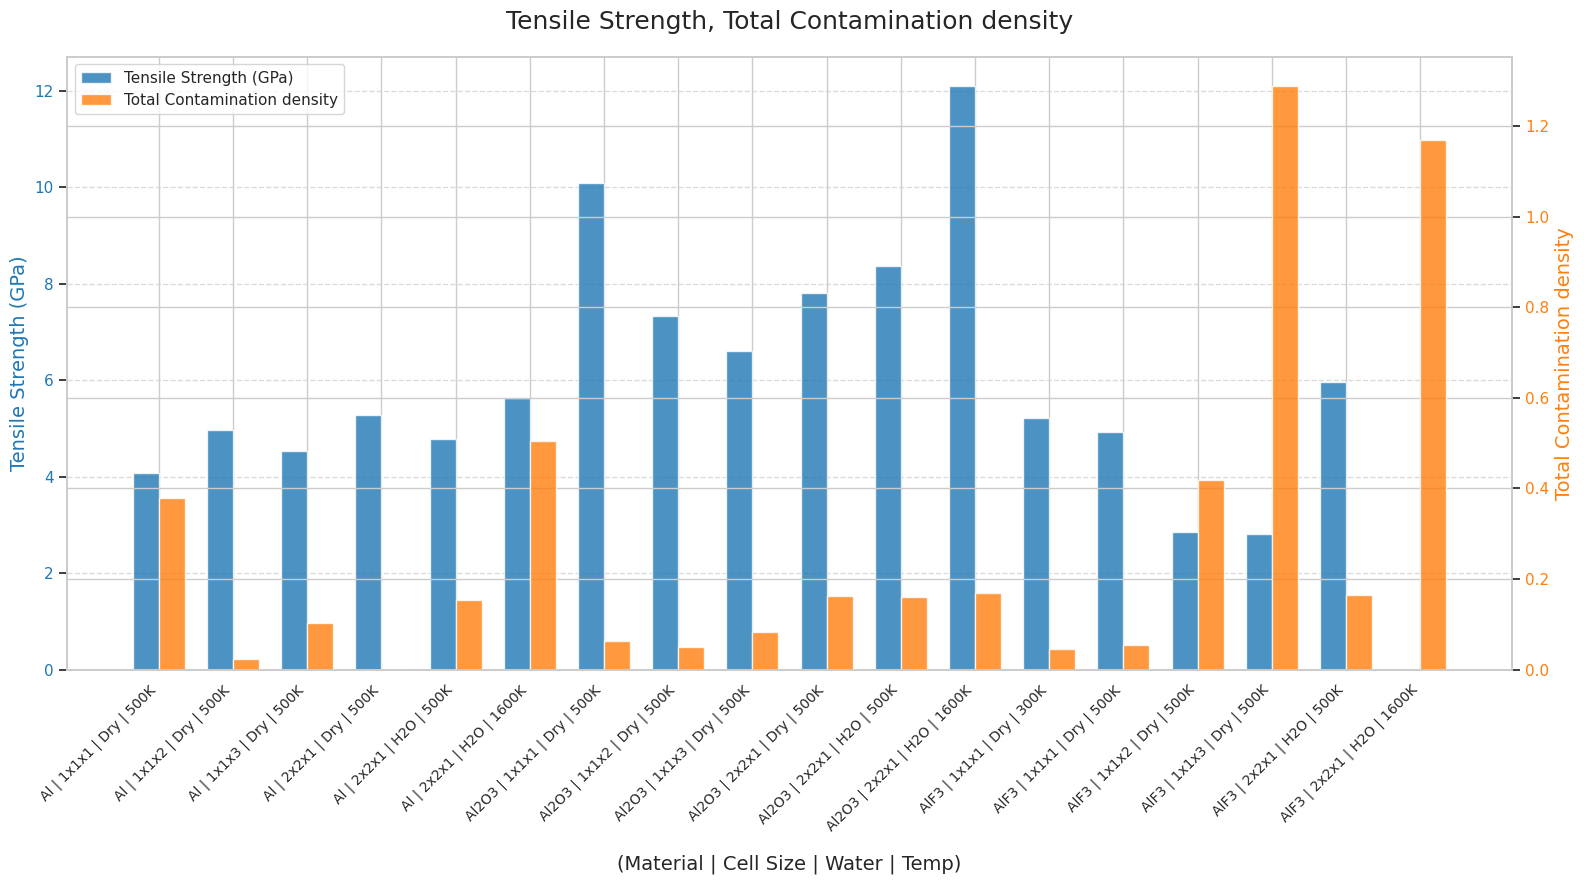

In [7]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

try:
    # 日本語の文字化けを防ぐために 'japanize_matplotlib' をインポート
    import japanize_matplotlib
except ImportError:
    print("警告: 'japanize_matplotlib' が見つかりません。")
    print("日本語が文字化けする可能性があります。")
    print("インストールするには: pip install japanize-matplotlib")

# --- 設定 ---

# (★要確認) 読み込むCSVファイルのパス
CSV_FILE_PATH = '/home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/scored_results_for_clean_separation.csv'

# (★要確認) グラフを保存するファイル名
OUTPUT_GRAPH_PATH = 'presentation_comparison_chart.png'

# --- 1. データの読み込みと前処理 ---

def load_and_preprocess_data(csv_path):
    """
    CSVを読み込み、フィルタリングとラベルの整形を行う。
    """
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"エラー: ファイル '{csv_path}' が見つかりません。")
        return None

    # 1. 'cell_original_cell' を除外
    # df_filtered = df[df['cell_size'] != 'cell_original_cell'].copy()
    # 'cell_size' 列の 'cell_original_cell' という文字列を '1x1x1' に置き換える
# .copy() は、元のDataFrame（df）に変更が及ばないようにコピーを作成する場合に付けます
    df_filtered = df.copy()
    df_filtered['cell_size'] = df_filtered['cell_size'].replace('cell_original_cell', '1x1x1')
    if df_filtered.empty:
        print("エラー: フィルタリング後（'cell_original_cell'除外後）のデータがありません。")
        return None

    # 2. 'cell_size' のラベルを短縮 (例: 'cell_repeat_2x2x1' -> '2x2x1')
    df_filtered['cell_size_label'] = df_filtered['cell_size'].str.replace('cell_repeat_', '', regex=False)
    
    # 3. 'water' のラベルを短縮 (例: 'with_H2O_d2_0' -> 'H2O', 'N/A' -> 'Dry')
    df_filtered['water_label'] = df_filtered['water'].apply(
        lambda x: 'H2O' if pd.notna(x) and 'with_H2O' in str(x) else 'Dry'
    )
    
    # 4. 'high_temp_K' をラベル化 (例: 500 -> '500K')
    df_filtered['temp_label'] = df_filtered['high_temp_K'].astype(str) + 'K'
    
    # 5. X軸用の複合ラベルを作成
    df_filtered['x_label'] = (
        df_filtered['material'] + ' | ' +
        df_filtered['cell_size_label'] + ' | ' +
        df_filtered['water_label'] + ' | ' +
        df_filtered['temp_label']
    )
    
    # データを並べ替えてグラフを見やすくする
    df_filtered = df_filtered.sort_values(by=['material', 'cell_size_label', 'water_label', 'high_temp_K'])
    
    return df_filtered

# --- 2. グラフの作成 ---

def create_comparison_chart(df, output_path):
    """
    Tensile StrengthとTotal Contamination densityの2軸棒グラフを作成して保存する。
    """
    if df is None or df.empty:
        print("グラフを作成するデータがありません。")
        return

    # X軸の位置設定
    x_labels = df['x_label']
    x_pos = np.arange(len(x_labels))
    bar_width = 0.35  # 棒グラフの幅

    # グラフ描画の設定
    fig, ax1 = plt.subplots(figsize=(16, 9))
    
    # Y1軸 (左): Tensile Strength (青色)
    color1 = 'tab:blue'
    ax1.set_xlabel('(Material | Cell Size | Water | Temp)', fontsize=14, labelpad=15)
    ax1.set_ylabel('Tensile Strength (GPa)', color=color1, fontsize=14)
    bar1 = ax1.bar(x_pos - bar_width/2, df['tensile_strength_GPa'], bar_width, 
                   label='Tensile Strength (GPa)', color=color1, alpha=0.8)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Y2軸 (右): Total Contamination density (オレンジ色)
    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.set_ylabel('Total Contamination density', color=color2, fontsize=14)
    bar2 = ax2.bar(x_pos + bar_width/2, df['total_contam_density'], bar_width, 
                   label='Total Contamination density', color=color2, alpha=0.8)
    ax2.tick_params(axis='y', labelcolor=color2)

    # X軸のラベル設定
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)

    # グラフのタイトルと凡例
    plt.title('Tensile Strength, Total Contamination density', fontsize=18, pad=20)
    
    # 凡例を結合して表示
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    fig.tight_layout()  # レイアウトを自動調整
    
    # グラフをファイルに保存
    try:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\nグラフを '{output_path}' に保存しました。")
    except Exception as e:
        print(f"グラフの保存中にエラーが発生しました: {e}")

# --- 3. メイン実行 ---
def main():
    print(f"'{CSV_FILE_PATH}' からデータを読み込み中...")
    processed_data = load_and_preprocess_data(CSV_FILE_PATH)
    
    if processed_data is not None:
        print(f"\n--- 前処理後のデータ ({len(processed_data)}件) ---")
        print(processed_data[['x_label', 'tensile_strength_GPa', 'total_contam_density']].to_markdown(index=False, floatfmt=".3f"))
        
        print("\nグラフの作成を開始します...")
        create_comparison_chart(processed_data, OUTPUT_GRAPH_PATH)

if __name__ == "__main__":
    main()

In [28]:
#  #-*- coding: utf-8 -*-
# import pandas as pd
# import matplotlib.pyplot as plt
# from ase.io import Trajectory
# from ase import units
# import sys
# import re
# import os
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from scipy import interpolate
# import glob
# from pathlib import Path

#  #--- 基本設定 ---
#  #!!! このパスは、.dat と .traj ファイルが保存されている実際のディレクトリに変更してください !!!
# TENSILE_DIR = "/home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/tensile01"
#  #Kaori/MD/LiB_2/structure/MD_Aあl/tensile01/Al2O3_NMC_Ni_decrease_001__P0.000_T300K_HT500K_tensile_analysis.dat
# TENSILE_TEMPERATURE = 300.0

#  #--- 出力ディレクトリの作成 ---
# OUTPUT_BASE_PATH = Path("/home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output")
# OUTPUT_FIGURE_DIR = OUTPUT_BASE_PATH / "stress_strain_curves"
# OUTPUT_BASE_PATH.mkdir(exist_ok=True)
# OUTPUT_FIGURE_DIR.mkdir(exist_ok=True)

#  #==============================================================================
#  #応力ひずみ解析モジュール (.dat ファイルベース)
#  #==============================================================================

# def calculate_yield_stress(strain_array, stress_array_mpa, youngs_modulus_mpa):
#     if np.isnan(youngs_modulus_mpa) or youngs_modulus_mpa == 0:
#         return np.nan, np.nan

#      #0.2%オフセットライン (y = E * (x - 0.002))
#     offset_line_stress = youngs_modulus_mpa * (strain_array - 0.002)
#      #元の応力曲線とオフセットラインの交点を探す
#     stress_diff = stress_array_mpa - offset_line_stress
#      #差分が0をまたぐ（符号が変わる）箇所を探す
#     sign_changes = np.where(np.diff(np.sign(stress_diff)))[0]

#      #0.002（2%ひずみ）より大きく、かつ応力が正の領域で、
#      #最初に交差する点を見つける
#     for idx in sign_changes:
#         if strain_array[idx] > 0.002 and stress_array_mpa[idx] > 0:
#              #線形補間で交点を精密に計算
#             x1, x2 = strain_array[idx], strain_array[idx+1]
#             y1_data, y2_data = stress_array_mpa[idx], stress_array_mpa[idx+1]
#             y1_off, y2_off = offset_line_stress[idx], offset_line_stress[idx+1]

#             try:
#                  #2直線の交点を求める
#                  #Data line: y = a1*x + b1
#                 a1 = (y2_data - y1_data) / (x2 - x1)
#                 b1 = y1_data - a1 * x1
#                  #Offset line: y = a2*x + b2 (a2 = E)ff
#                 a2 = youngs_modulus_mpa
#                 b2 = -0.002 * youngs_modulus_mpa

#                  #交点のx座標 (a1*x + b1 = a2*x + b2)
#                 if (a1 - a2) == 0: continue  #平行
                
#                 intersection_strain = (b2 - b1) / (a1 - a2)
#                 intersection_stress = a1 * intersection_strain + b1
                
#                  #交点がセグメント内にあることを確認
#                 if x1 <= intersection_strain <= x2:
#                         return intersection_stress, intersection_strain
#             except ZeroDivisionError:
#                 continue

#     return np.nan, np.nan


# def analyze_stress_strain_from_dat(dat_file_path):
#     """
#     .datファイルから応力ひずみ曲線を解析し、機械特性を計算する。
#     応力(Stress)列を「圧力(圧縮が正)」とみなし、-1を乗じて「応力(引張が正)」に変換する。
#     応力が0に最も近い点を解析開始点（ひずみ0）として扱う。
#     """
#      #(注: この関数はユーザーが提供した2つのバージョンのうち、2番目のものを採用しています)
#     results = {
#         'youngs_modulus_GPa': np.nan,
#         'tensile_strength_GPa': np.nan,
#         'yield_stress_GPa_0.2offset': np.nan,
#         'intersection_strain': np.nan,
#         'strain_at_zero_stress': 0.0,  #プロット用にゼロ点ひずみを保存
#         'stress_at_zero_stress_GPa': 0.0  #プロット用にゼロ点応力を保存
#     }
#     try:
#         data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,
#                             names=['Step', 'Strain', 'Stress(GPa)', 'YoungMod(GPa)', 'Status', 'Time(ps)', 'InterfaceNotes'])
#         if data.empty:
#             return results, None

#          #--- 修正点 1: 応力の符号を universally 修正 ---
#         strain = data['Strain'].values
#         stress_gpa = data['Stress(GPa)'].values 
        
#          #--- 修正点 2: 解析開始点（応力ゼロ点）の特定 ---
#         zero_stress_index = np.abs(stress_gpa).argmin()

#         strain_offset = strain[zero_stress_index]
#         stress_offset_gpa = stress_gpa[zero_stress_index]
#         results['strain_at_zero_stress'] = strain_offset
#         results['stress_at_zero_stress_GPa'] = stress_offset_gpa

#          #--- 修正点 3: 解析用データ（スライス）の作成 ---
#         strain_analysis_raw = strain[:]
#         stress_gpa_analysis_raw = stress_gpa[:]

#         strain_analysis = strain_analysis_raw - strain_offset
#         stress_gpa_analysis = stress_gpa_analysis_raw - stress_offset_gpa
#         stress_mpa_analysis = stress_gpa_analysis * 1000

#         if strain_analysis.size < 2:
#             return results, None

#          #--- 修正点 4: スライスしたデータで解析 ---
#         linear_range_mask = (strain_analysis >= 0.0) & (strain_analysis <= 0.05)
        
#         if np.sum(linear_range_mask) > 1:
#             X = strain_analysis[linear_range_mask].reshape(-1, 1)
#             y = stress_mpa_analysis[linear_range_mask]
            
#             linear_model = LinearRegression(fit_intercept=False).fit(X, y)
#             youngs_modulus_mpa = linear_model.coef_[0]
            
#             if youngs_modulus_mpa > 0:
#                 results['youngs_modulus_GPa'] = youngs_modulus_mpa / 1000
#             else:
#                 youngs_modulus_mpa = np.nan
#         else:
#             youngs_modulus_mpa = np.nan

#          #最大Tensile Strength (オフセット前の応力での最大値)
#         results['tensile_strength_GPa'] = stress_gpa_analysis_raw.max()

#          #降伏応力の計算 (0.2% オフセット)
#         yield_stress_mpa, intersection_strain_relative = calculate_yield_stress(strain_analysis, stress_mpa_analysis, youngs_modulus_mpa)
        
#         if not np.isnan(yield_stress_mpa):
#             results['yield_stress_GPa_0.2offset'] = (yield_stress_mpa + stress_offset_gpa * 1000) / 1000
#             results['intersection_strain'] = intersection_strain_relative + strain_offset
        
#          #プロット用には、符号を修正した「全体」のデータを渡す
#         plot_data = pd.DataFrame({'strain': strain, 'stress': stress_gpa * 1000})
        
#         return results, plot_data
    
#     except Exception as e:
#         print(f"  - .datファイルの解析中にエラー: {e}")
#         return results, None

#  #==============================================================================
#  #破断界面解析モジュール
#  #==============================================================================

# def find_fracture_step(traj, void_size=3.0, search_region_ratio=2.0/3.0):
#     """Trajectoryをスキャンし、指定サイズの真空層（void）を検出します。"""
#     if not traj:
#         return None, -1, -1
#     for i, atoms in enumerate(traj):
#         cell = atoms.get_cell()
#         lz = cell[2, 2]
#         z_max_search = lz * search_region_ratio
#         positions = atoms.get_positions()
#         z_coords = positions[:, 2]
#         in_region_mask = (z_coords >= 10.0) & (z_coords < z_max_search)
#         region_z_coords = z_coords[in_region_mask]
#         if len(region_z_coords) < 2:
#             continue
#         sorted_z = np.sort(region_z_coords)
#         gaps = sorted_z[1:] - sorted_z[:-1]
#         if np.any(gaps >= void_size):
#             max_gap_index = np.argmax(gaps)
#             fracture_z = (sorted_z[max_gap_index] + sorted_z[max_gap_index + 1]) / 2.0
#             return atoms, i, fracture_z
#     return None, -1, -1

# def analyze_distribution_at_fracture(atoms, z_boundary):
#     """
#     破断瞬間の原子スナップショットを基に、境界面上下の原子分布を解析する。
#     """
#     symbols = atoms.get_chemical_symbols()
#     positions = atoms.get_positions()
#      #(注: Li, Mn, Co, Ni を含めないように、ユーザーが提供した
#      #1番目のスクリプトの elements_to_count を採用しています)
#     elements_to_count = [ "O", "C", "F"] 
#     results = {elem: {'upper': 0, 'lower': 0, 'total': 0} for elem in elements_to_count}
#      #NMC系の原子もカウント対象に含める（calculate_contamination_densityで利用）
#     other_elements = ["Li", "Mn", "Co", "Ni"]
#     for elem in other_elements:
#         if elem not in results:
#             results[elem] = {'upper': 0, 'lower': 0, 'total': 0}

#     for i, symbol in enumerate(symbols):
#         if symbol in results:
#             results[symbol]['total'] += 1
#             if positions[i, 2] > z_boundary:
#                 results[symbol]['upper'] += 1
#             else:
#                 results[symbol]['lower'] += 1
#     return results

#  #==============================================================================
#  #ヘルパー関数 (Miller指数読み取り, プロット, スコアリング)
#  #==============================================================================

# def get_miller_index_from_summary(summary_file_path):
#     """_summary.txt ファイルから NMC Miller 指数を抽出する。"""
#      #(注: この関数は run_comprehensive_analysis_with_dat 内では
#      #コメントアウトされているため、呼び出されません)
#     if not os.path.exists(summary_file_path):
#         return "N/A"
#     try:
#         with open(summary_file_path, 'r', encoding='utf-8') as f:
#             for line in f:
#                 if line.strip().startswith("NMC Miller指数:"):
#                     return line.split(':', 1)[1].strip()
#     except Exception as e:
#         print(f"  [警告] summary.txtの読み取り中にエラー: {e}")
#         return "Error"
#     return "Not Found"

# def plot_stress_strain_curve(data, analysis_results, file_identifier, output_dir):
#     """応力-ひずみ曲線と解析結果をプロットして保存する。"""
#      #(注: この関数はユーザーが提供した2つのバージョンのうち、2番目のものを採用しています)
#     if data is None or data.empty: return
    
#     fig_path = os.path.join(output_dir, f"{file_identifier}_ss_curve.png")
#     plt.figure(figsize=(10, 7))

#      #--- 修正点 1: プロットデータを準備 ---
#     stress_gpa = data['stress'] / 1000
#     strain = data['strain']
    
#     plt.plot(strain, stress_gpa, label='Stress-Strain Curve', alpha=0.7)
    
#     strain_at_zero = analysis_results.get('strain_at_zero_stress', 0.0)
#     stress_at_zero_gpa = analysis_results.get('stress_at_zero_stress_GPa', 0.0)
#     youngs_modulus_gpa = analysis_results.get('youngs_modulus_GPa', np.nan)

#      #--- 修正点 2: ヤング率のフィット線をゼロ点から描画 ---
#     if not np.isnan(youngs_modulus_gpa):
#         fit_strain_end = strain_at_zero + 0.05
#         fit_strain_end = min(fit_strain_end, strain.max())
        
#         linear_range_strain = np.linspace(strain_at_zero, fit_strain_end, 10)
#          #y = m * (x - x0) + y0
#         linear_fit_gpa = youngs_modulus_gpa * (linear_range_strain - strain_at_zero) + stress_at_zero_gpa
        
#         plt.plot(linear_range_strain, linear_fit_gpa, 'r-', linewidth=2, 
#                     label=f'Young\'s Modulus Fit ({youngs_modulus_gpa:.1f} GPa)')

#     yield_stress_gpa = analysis_results.get('yield_stress_GPa_0.2offset', np.nan)
#     intersection_strain = analysis_results.get('intersection_strain', np.nan)  #絶対ひずみ

#      #--- 修正点 3: オフセット線をゼロ点基準で描画 ---
#     if not np.isnan(yield_stress_gpa) and not np.isnan(intersection_strain) and not np.isnan(youngs_modulus_gpa):
#         offset_start_strain = strain_at_zero + 0.002
#         offset_strain_range = np.linspace(offset_start_strain, strain.max(), 100)
        
#          #y = m * (x - (x0 + 0.002)) + y0
#         offset_line_gpa = youngs_modulus_gpa * (offset_strain_range - offset_start_strain) + stress_at_zero_gpa

#         plt.plot(offset_strain_range, offset_line_gpa, 'g--', label='0.2% Offset Line')
        
#         plt.scatter([intersection_strain], [yield_stress_gpa], color='orange', s=150, 
#                     marker='*', zorder=5, label=f'Yield Point ({yield_stress_gpa:.2f} GPa)')

#     plt.title(f'Stress-Strain Curve for {file_identifier}', fontsize=14)
#     plt.xlabel('Strain', fontsize=12)
#     plt.ylabel('Stress (GPa)', fontsize=12)
    
#     plt.axhline(0, color='black', linestyle=':', linewidth=1, label='Zero Stress')
    
#     plt.legend()
#     plt.grid(True, linestyle='--', alpha=0.6)
#     plt.tight_layout()
#     plt.savefig(fig_path, dpi=300)
#     plt.close()

# def calculate_clean_separation_score(df):
#     """界面がどれだけきれいに分離したかを評価するスコアを計算する。"""
#      #(注: この関数はユーザーが提供した2つのバージョンのうち、1番目のものを採用しています)
#     if 'Al_total' in df.columns and df['Al_total'].sum() > 0:
#         df['substrate_stability'] = (df['Al_lower'] / df['Al_total']).fillna(0)
#     else:
#         df['substrate_stability'] = 0.5  #Alがない場合は 0.5 とする
    
#     cathode_elements = ['Li', 'Mn', 'Co', 'Ni']
#     upper_sum = pd.Series(0, index=df.index)
#     total_sum = pd.Series(0, index=df.index)
    
#     for elem in cathode_elements:
#         if f'{elem}_total' in df.columns:
#             upper_sum += df[f'{elem}_upper'].fillna(0)
#             total_sum += df[f'{elem}_total'].fillna(0)
            
#      #total_sum が 0 の場合に 0/0 = NaN となるのを防ぐ
#     df['cathode_stability'] = (upper_sum / total_sum.replace(0, np.nan)).fillna(0.5)  #カソードがない場合は 0.5
    
#     df['clean_separation_score'] = (df['substrate_stability'] + df['cathode_stability']) / 2
#     return df
# # import pandas as pd
# # import numpy as np

# def calculate_contamination_density(df):
#     """
#     剥離界面の混入度合いを「単位面積あたりの混入原子数 (areal density)」で計算する。
#     混入を「基板(Al)」「NMC」「樹脂(PVDF)」に分けて個別にカウントするよう修正。
#     """
#     if 'cell_x' not in df.columns or 'cell_y' not in df.columns:
#         print("[警告] Total Contamination density計算: 'cell_x' または 'cell_y' カラムが見つかりません。")
#         df['sub_contam_density'] = np.nan
#         df['nmc_contam_density'] = np.nan   # (変更)
#         df['resin_contam_density'] = np.nan # (変更)
#         df['total_contam_density'] = np.nan
#         return df

#     area_XY = df['cell_x'] * df['cell_y']
#     area_XY_safe = area_XY.replace(0, np.nan)

#     #--- 1. 基板原子 (Al) のTotal Contamination density ---
#     # (基板(Al)が上部(upper)へ移動したもの)
#     substrate_element = 'Al'
#     substrate_contamination_count = pd.Series(0, index=df.index, dtype=float)
#     col_name = f'{substrate_element}_upper' 
#     if col_name in df.columns:
#         substrate_contamination_count = df[col_name].fillna(0)
    
#     df['sub_contam_density'] = (
#         substrate_contamination_count / area_XY_safe 
#     ).fillna(0) 

#     #--- 2. NMC原子 (カソード) のTotal Contamination density ---
#     # (NMCが下部(lower)に残ったもの)
#     nmc_elements = ['Li', 'Mn', 'Co', 'Ni']
#     nmc_contamination_count = pd.Series(0, index=df.index, dtype=float)
    
#     for elem in nmc_elements:
#         col_name = f'{elem}_lower' # 'lower' に残ったものをカウント
#         if col_name in df.columns:
#             nmc_contamination_count += df[col_name].fillna(0)
            
#     df['nmc_contam_density'] = (
#         nmc_contamination_count / area_XY_safe
#     ).fillna(0) 

#     #--- 3. 樹脂原子 (PVDF) のTotal Contamination density ---
#     # (樹脂(C, H, F)が下部(lower)に残ったもの)
#     resin_elements = ['C', 'F'] # CH2CF2 (PVDF) の構成元素
#     resin_contamination_count = pd.Series(0, index=df.index, dtype=float)
    
#     for elem in resin_elements:
#         col_name = f'{elem}_lower' # 'lower' に残ったものをカウント
#         if col_name in df.columns:
#             resin_contamination_count += df[col_name].fillna(0)
            
#     df['resin_contam_density'] = (
#         resin_contamination_count / area_XY_safe
#     ).fillna(0) 

#     #--- 4. 合計Total Contamination density ---
#     df['total_contam_density'] = (
#         df['sub_contam_density'] + 
#         df['nmc_contam_density'] +  # (変更)
#         df['resin_contam_density']  # (変更)
#     )
    
#     return df
# # def calculate_contamination_density(df):
# #     """
# #     剥離界面の混入度合いを「単位面積あたりの混入原子数 (areal density)」で計算する。
# #     """
# #     if 'cell_x' not in df.columns or 'cell_y' not in df.columns:
# #         print("[警告] Total Contamination density計算: 'cell_x' または 'cell_y' カラムが見つかりません。")
# #          #ダミーカラムを追加して処理を続行
# #         df['sub_contam_density'] = np.nan
# #         df['cat_contam_density'] = np.nan
# #         df['total_contam_density'] = np.nan
# #         return df

# #     area_XY = df['cell_x'] * df['cell_y']
# #     area_XY_safe = area_XY.replace(0, np.nan)

# #      #--- 1. 基板原子 (Al) のTotal Contamination density ---
# #     substrate_element = 'Al'
# #     substrate_contamination_count = pd.Series(0, index=df.index, dtype=float)
# #     col_name = f'{substrate_element}_upper' 
# #     if col_name in df.columns:
# #         substrate_contamination_count = df[col_name].fillna(0)
    
# #     df['sub_contam_density'] = (
# #         substrate_contamination_count / area_XY_safe 
# #     ).fillna(0) 

# #      #--- 2. カソード原子のTotal Contamination density ---
# #     cathode_elements = ['Li', 'Mn', 'Co', 'Ni','C','F']
# #     cathode_contamination_count = pd.Series(0, index=df.index, dtype=float)
# #     for elem in cathode_elements:
# #         col_name = f'{elem}_lower'
# #         if col_name in df.columns:
# #             cathode_contamination_count += df[col_name].fillna(0)
            
# #     df['cat_contam_density'] = (
# #         cathode_contamination_count / area_XY_safe
# #     ).fillna(0) 

# #      #--- 3. 合計Total Contamination density ---
# #     df['total_contam_density'] = (
# #         df['sub_contam_density'] + 
# #         df['cat_contam_density']
# #     )
    
# #     return df

# def normalize_metric(series, high_is_good=True):
#     """PandasのSeriesをミンマックス正規化する。"""
#     series_finite = series.replace([np.inf, -np.inf], np.nan).fillna(0)
#     min_val, max_val = series_finite.min(), series_finite.max()
#     if max_val - min_val == 0:
#         return pd.Series(0.5, index=series.index)
#     if high_is_good:
#         return (series_finite - min_val) / (max_val - min_val)
#     else:
#         return (max_val - series_finite) / (max_val - min_val)

# def score_for_clean_separation(csv_path=OUTPUT_BASE_PATH/"comprehensive_analysis_results.csv"):
#     """「分離しやすく、きれいな分離」という基準で結果をスコアリングする。"""
#     try:
#         df = pd.read_csv(csv_path)
#     except FileNotFoundError:
#         print(f"エラー: ファイルが見つかりません '{csv_path}'")
#         return
#     print("\n\n=== スコアリングを開始します ===")
    
#      #評価指標が 'fracture_step' しかないため、
#      #'total_contam_density' を calculate_contamination_density で計算
#     if 'total_contam_density' not in df.columns:
#          df = calculate_contamination_density(df)

#     metrics_config = {
#         'tensile_strength_GPa': {'weight': 0.4, 'high_is_good': False},
#         'fracture_step':        {'weight': 0.2, 'high_is_good': False},
#         'total_contam_density': {'weight': 0.4, 'high_is_good': False},
#     }
    
#     df['総合スコア'] = 0.0
#     print("\n評価指標と方針:")
    
#      #calculate_clean_separation_score の呼び出しは不要（total_contam_density を直接使用するため）
#      #df = calculate_clean_separation_score(df) 
    
#     for metric, config in metrics_config.items():
#         if metric not in df.columns:
#             print(f"  [警告] スコアリング: {metric} カラムが見つかりません。スキップします。")
#             continue
            
#         direction = "低いほど高評価" if not config['high_is_good'] else "高いほど高評価"
#         print(f"- {metric}: 重み {config['weight']*100:.0f}%, ({direction})")
        
#          #欠損値を適切に処理 (fillna(0) ではなく、スコアリングに影響しないように)
#          #ここでは「低いほど良い」指標ばかりなので、
#          #欠損値(NaN)は「最悪の値（最大値）」で埋めるのが妥当
#         metric_series = df[metric].replace([np.inf, -np.inf], np.nan)
#         if not config['high_is_good']:
#             fill_value = metric_series.max()  #低い方が良い -> 欠損は最大値
#         else:
#             fill_value = metric_series.min()  #高い方が良い -> 欠損は最小値
            
#         if pd.isna(fill_value): fill_value = 0  #全てNaNだった場合
            
#         metric_series = metric_series.fillna(fill_value)

#         normalized_col_name = f'norm_{metric}'
#         df[normalized_col_name] = normalize_metric(metric_series, high_is_good=config['high_is_good'])
#         df['総合スコア'] += df[normalized_col_name].fillna(0) * config['weight']  #正規化後のNaNは0でよい

#     df['総合スコア'] *= 100
#     df_sorted = df.sort_values(by='総合スコア', ascending=False)
    
#      #<--- 変更点 5: スコアリング表示カラムの追加 ---
#      #表示するカラムリストを動的に生成
#     display_columns = ['substrate', 'material', 'cell_size', 'water', 'NMC_miller_index', 'pressure_GPa', 'high_temp_K', '総合スコア']
#      #<--- 変更点 5 終了 ---
#     display_columns.extend([col for col in metrics_config.keys() if col in df.columns])
    
#     print("\n--- スコアリング結果トップ10 (分離しやすさ・きれいさ重視) ---")
#     print(df_sorted[display_columns].head(10).round(2))
    
#     output_filename = OUTPUT_BASE_PATH/"scored_results_for_clean_separation.csv"
#     df_sorted.to_csv(output_filename, index=False)
#     print(f"\n全スコアリング結果を '{output_filename}' に保存しました。")


#  #==============================================================================
#  #メイン実行ブロック
#  #==============================================================================

# def run_comprehensive_analysis_with_dat():
#     dat_paths = glob.glob(os.path.join(TENSILE_DIR, '*_tensile_analysis.dat'))
#     if not dat_paths:
#         print(f"エラー: ディレクトリ '{TENSILE_DIR}' 内に `..._tensile_analysis.dat` ファイルが見つかりません。")
#         return

#     all_results_list = []
#     total_files = len(dat_paths)
#     print(f"=== 包括的解析を開始します (.datファイルベース, 対象ファイル数: {total_files}) ===")
    
#     for i, dat_path in enumerate(dat_paths):
#         filename = os.path.basename(dat_path)
#         print(f"\n--- ({i+1}/{total_files}) 処理中: {filename} ---")
        
#          #<--- 変更点 1: 正規表現の修正 (圧力が P0.000 と P0 の両方に対応)
#         pattern = re.compile(r'([^_]+)_(.*)__P(\d+(?:\.\d+)?)_T(\d+)K_HT(\d+)K_tensile_analysis\.dat')
#          #<--- 変更点 1 終了
        
#         match = pattern.match(filename)
#         if not match:
#             print(f"  [スキップ] ファイル名の形式がパターンに一致しません: {filename}")
#             continue
            
#          #P0 の場合でも float(pressure) が動作することを確認
#         groups = match.groups()
        
#          #グループ数が期待通りか確認（デバッグ用）
#          #期待されるグループ: (sub, base_name, pressure, (None or .decimal), comp_temp, high_temp)
#          #P(\d+(?:\.\d+)?) のせいでグループ数が5つではない可能性をチェック
#          #(注: `(?:\.\d+)?` は非キャプチャグループなので、グループ数は5つのはず)
#         if len(groups) != 5:
#               #キャプチャグループが (sub, base_name, pressure_int, pressure_dec, comp_temp, high_temp) 
#               #のように6つになってしまった場合のフォールバック
#               #(r'([^_]+)_(.*)__P(\d+(\.\d+)?)_T(\d+)K_HT(\d+)K_tensile_analysis\.dat') の場合
#              if len(groups) == 6:
#                  sub, base_name, pressure, _, comp_temp, high_temp = groups
#                  print("  [Debug] Regex matched 6 groups.")
#              else:
#                 print(f"  [エラー] Regexのグループ数が不正です。期待値 5, 実際 {len(groups)}")
#                 continue
#         else:
#             sub, base_name, pressure, comp_temp, high_temp = groups
#              #print("  [Debug] Regex matched 5 groups.")

        
#         try:
#             pressure, comp_temp, high_temp = float(pressure), int(comp_temp), int(high_temp)
#         except ValueError as e:
#             print(f"  [エラー] 数値への変換に失敗: {e}")
#             continue

#          #<--- 変更点 2 (改): 'NMC' の有無とPVDF系の詳細パース ---
#         split_list = base_name.split('_')
#         additional_data = {}  #新しいカラム (cell_size, water) 用の辞書
        
#         try:
#              #--- 従来のNMC系ファイル名の解析ロジック ---
#             nmc_index = split_list.index('NMC')
            
#              #'NMC'の次から最後の要素の手前までを 'material' とする
#             composition_parts = split_list[nmc_index + 1 : -1]
#             if not composition_parts:
#                 material = "NMC_base"
#             else:
#                     material = '_'.join(composition_parts)
            
#              #最後の要素をMiller指数とする
#             nmc_miller_index = f"{int(split_list[-1]):03d}"
#             print(f"  [Info] NMC系と判断: material={material}, miller={nmc_miller_index}")
#              #NMC系は cell_size, water は N/A とする
#             additional_data = {'cell_size': 'N/A', 'water': 'N/A'}

#         except (ValueError, IndexError):
#              #--- 'NMC' が含まれない場合のロジック (PVDF系など) ---
#             print(f"  [Info] non-NMC系と判断: base_name={base_name}")
#             nmc_miller_index = "N/A"
            
#              #1. 'press_on_' や 'on_' の接頭辞を削除
#             parsed_name = base_name
#             if parsed_name.startswith('press_on_'):
#                 parsed_name = parsed_name[len('press_on_'):]
#             elif parsed_name.startswith('on_'):
#                 parsed_name = parsed_name[len('on_'):]

#              #2. 正規表現で material, cell_size, water を抽出
#                 #例: AlF3_cell_repeat_2x2x1_with_H2O_d2_0
#                 #例: Al_metal
#                 #例: Al2O3_cell_repeat_2x2x1
#             pvdf_pattern = re.compile(
#                 r'^(?P<material>AlF3|Al2O3|Al(?:_metal)?)(?:_(?P<cell_size>cell_repeat_[^_]+|cell_original_cell))?(?:_(?P<water>with_H2O_.+))?$'
#             )
            
#             match_pvdf = pvdf_pattern.match(parsed_name)
            
#             if match_pvdf:
#                 parts = match_pvdf.groupdict()
#                 material = parts.get('material', parsed_name)  #必須
#                 if material == 'Al_metal':
#                     material = 'Al'
#                 # cell_size = parts.get('cell_size', 'cell_original_cell')
#                 cell_size = parts.get('cell_size') or 'cell_original_cell'
#                 water = parts.get('water', 'N/A')
#                 print(f"    -> Parsed: Mat={material}, Size={cell_size}, Water={water}")
#                 additional_data = {'cell_size': cell_size, 'water': water}
#             else:
#                 material = parsed_name  #パターンに合わなければ、prefix削除後の名前
#                 print(f"    -> Parse Warning: Pattern did not match. Using '{material}' as material.")
#                 additional_data = {'cell_size': 'N/A', 'water': 'N/A'}
        
#         print(f"  抽出された material: {material}")
#          #<--- 変更点 2 (改) 終了 ---

#          #(Miller指数をsummary.txtから読む処理はコメントアウト)
#          #summary_filename1 = filename.replace('_analysis.dat', '_summary.txt')
#          #...
#          #nmc_miller_index = get_miller_index_from_summary(summary_path)

#          #応力ひずみ解析
#         ss_results, ss_data = analyze_stress_strain_from_dat(dat_path)
#         if ss_data is not None:
#             print("  応力ひずみ解析完了。")
#             file_identifier = f"{sub}_{base_name}_P{pressure:.3f}_T{comp_temp:.0f}K_HT{high_temp}K"
#             plot_stress_strain_curve(ss_data, ss_results, file_identifier, OUTPUT_FIGURE_DIR)
#         else:
#             print("  応力ひずみ解析不可。")

#          #破断界面解析
#         traj_filename1 = filename.replace('_tensile_analysis.dat', f'_tensile{TENSILE_TEMPERATURE:.0f}K.traj')
#         traj_filename = traj_filename1.replace('__', '_')
#         traj_path = os.path.join(TENSILE_DIR, traj_filename)
#         fracture_results = {}
#         if os.path.exists(traj_path):
#             try:
#                 traj = Trajectory(traj_path, 'r')
#                 if len(traj) > 0:
#                     fracture_results[f'cell_x'] = traj[0].cell[0,0]
#                     fracture_results[f'cell_y'] = traj[0].cell[1,1]
#                     fracture_results[f'cell_z'] = traj[0].cell[2,2]
                    
#                     fractured_atoms, step, z_loc = find_fracture_step(traj)
#                     if fractured_atoms is not None:
#                         print(f"  破断を発見 (ステップ: {step}, Z座標: {z_loc:.2f} Å)。")
#                         dist = analyze_distribution_at_fracture(fractured_atoms, z_loc)
#                         fracture_results.update({'fracture_step': step, 'fracture_z': z_loc})
#                         for elem, counts in dist.items():
#                             fracture_results[f'{elem}_upper'] = counts['upper']
#                             fracture_results[f'{elem}_lower'] = counts['lower']
#                             fracture_results[f'{elem}_total'] = counts['total']
#                     else:
#                         print("  指定サイズのギャップは見つかりませんでした。")
#                 else:
#                     print(f"  [警告] .traj ファイルが空です: {traj_filename}")
#             except Exception as e:
#                 print(f"  [エラー] .trajファイルの処理中に問題が発生: {e}")
#         else:
#             print(f"  [警告] 対応する .traj ファイルが見つかりません: {traj_filename}")

#          #結果を統合
#         row = {'substrate': sub, 'material': material, 'pressure_GPa': pressure, 
#                 'comp_temp_K': comp_temp, 'high_temp_K': high_temp, 'NMC_miller_index': nmc_miller_index}
        
#          #<--- 変更点 3: パースした 'cell_size', 'water' を追加 ---
#         row.update(additional_data) 
#          #<--- 変更点 3 終了 ---
        
#         row.update(ss_results)
#         row.update(fracture_results)
#         all_results_list.append(row)

#     print("\n\n=== すべての解析が完了しました ===")
#     if not all_results_list:
#         print("有効な解析結果がありませんでした。")
#         return

#      #結果をCSVに保存
#     df = pd.DataFrame(all_results_list)
    
#      #<--- 変更点 4: basic_cols に 'cell_size', 'water' を追加 ---
#     basic_cols = ['substrate', 'material', 'cell_size', 'water', 'NMC_miller_index', 'pressure_GPa', 'comp_temp_K', 'high_temp_K']
#      #存在しないカラムを除外
#     existing_basic_cols = [col for col in basic_cols if col in df.columns]
#     analysis_cols = [col for col in df.columns if col not in existing_basic_cols]
    
#     df = df[existing_basic_cols + analysis_cols]
#      #<--- 変更点 4 終了 ---
    
#     output_csv_path = OUTPUT_BASE_PATH / "comprehensive_analysis_results.csv"
#     df.to_csv(output_csv_path, index=False)
#     print(f"結果を {output_csv_path} に保存しました。")

# if __name__ == "__main__":
#      #1. メインの解析を実行
#     run_comprehensive_analysis_with_dat()
    
#      #2. 生成されたCSVファイルを使ってスコアリングを実行
#     score_for_clean_separation()

=== 包括的解析を開始します (.datファイルベース, 対象ファイル数: 12) ===

--- (1/12) 処理中: PVDF_on_Al2O3_cell_repeat_2x2x1__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_Al2O3_cell_repeat_2x2x1
    -> Parsed: Mat=Al2O3, Size=cell_repeat_2x2x1, Water=None
  抽出された material: Al2O3
  応力ひずみ解析完了。


/tmp/ipykernel_46/3882889369.py:91: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 157, Z座標: 57.18 Å)。

--- (2/12) 処理中: PVDF_on_AlF3_cell_repeat_2x2x1_with_H2O_d2_0__P0.000_T300K_HT1600K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_AlF3_cell_repeat_2x2x1_with_H2O_d2_0
    -> Parsed: Mat=AlF3, Size=cell_repeat_2x2x1, Water=with_H2O_d2_0
  抽出された material: AlF3
  応力ひずみ解析完了。


/tmp/ipykernel_46/3882889369.py:91: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 0, Z座標: 609140.19 Å)。

--- (3/12) 処理中: PVDF_on_AlF3_cell_repeat_2x2x1_with_H2O_d2_0__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_AlF3_cell_repeat_2x2x1_with_H2O_d2_0
    -> Parsed: Mat=AlF3, Size=cell_repeat_2x2x1, Water=with_H2O_d2_0
  抽出された material: AlF3
  応力ひずみ解析完了。


/tmp/ipykernel_46/3882889369.py:91: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 74, Z座標: 35.41 Å)。

--- (4/12) 処理中: PVDF_press_on_AlF3__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=press_on_AlF3
    -> Parsed: Mat=AlF3, Size=cell_original_cell, Water=None
  抽出された material: AlF3
  応力ひずみ解析完了。


/tmp/ipykernel_46/3882889369.py:91: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 49, Z座標: 28.38 Å)。

--- (5/12) 処理中: PVDF_press_on_Al2O3__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=press_on_Al2O3
    -> Parsed: Mat=Al2O3, Size=cell_original_cell, Water=None
  抽出された material: Al2O3
  応力ひずみ解析完了。


/tmp/ipykernel_46/3882889369.py:91: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 58, Z座標: 30.05 Å)。

--- (6/12) 処理中: PVDF_press_on_Al_metal__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=press_on_Al_metal
    -> Parsed: Mat=Al, Size=cell_original_cell, Water=None
  抽出された material: Al
  応力ひずみ解析完了。


/tmp/ipykernel_46/3882889369.py:91: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 111, Z座標: 49.62 Å)。

--- (7/12) 処理中: PVDF_on_AlF3_cell_repeat_1x1x2__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_AlF3_cell_repeat_1x1x2
    -> Parsed: Mat=AlF3, Size=cell_repeat_1x1x2, Water=None
  抽出された material: AlF3
  応力ひずみ解析完了。


/tmp/ipykernel_46/3882889369.py:91: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 87, Z座標: 70.84 Å)。

--- (8/12) 処理中: PVDF_on_Al2O3_cell_repeat_2x2x1_with_H2O_d2_0__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_Al2O3_cell_repeat_2x2x1_with_H2O_d2_0
    -> Parsed: Mat=Al2O3, Size=cell_repeat_2x2x1, Water=with_H2O_d2_0
  抽出された material: Al2O3
  応力ひずみ解析完了。


/tmp/ipykernel_46/3882889369.py:91: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 105, Z座標: 44.18 Å)。

--- (9/12) 処理中: PVDF_on_Al_cell_repeat_2x2x1__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_Al_cell_repeat_2x2x1
    -> Parsed: Mat=Al, Size=cell_repeat_2x2x1, Water=None
  抽出された material: Al
  応力ひずみ解析完了。


/tmp/ipykernel_46/3882889369.py:91: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  指定サイズのギャップは見つかりませんでした。

--- (10/12) 処理中: PVDF_on_Al_cell_repeat_2x2x1_with_H2O_d2_0__P0.000_T300K_HT500K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_Al_cell_repeat_2x2x1_with_H2O_d2_0
    -> Parsed: Mat=Al, Size=cell_repeat_2x2x1, Water=with_H2O_d2_0
  抽出された material: Al
  応力ひずみ解析完了。


/tmp/ipykernel_46/3882889369.py:91: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 188, Z座標: 50.24 Å)。

--- (11/12) 処理中: PVDF_on_Al_cell_repeat_2x2x1_with_H2O_d2_0__P0.000_T300K_HT1600K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=on_Al_cell_repeat_2x2x1_with_H2O_d2_0
    -> Parsed: Mat=Al, Size=cell_repeat_2x2x1, Water=with_H2O_d2_0
  抽出された material: Al
  応力ひずみ解析完了。


/tmp/ipykernel_46/3882889369.py:91: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  指定サイズのギャップは見つかりませんでした。

--- (12/12) 処理中: PVDF_press_on_AlF3__P0.000_T300K_HT300K_tensile_analysis.dat ---
  [Info] non-NMC系と判断: base_name=press_on_AlF3
    -> Parsed: Mat=AlF3, Size=cell_original_cell, Water=None
  抽出された material: AlF3
  応力ひずみ解析完了。


/tmp/ipykernel_46/3882889369.py:91: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(dat_file_path, comment='#', delim_whitespace=True, header=None,


  破断を発見 (ステップ: 55, Z座標: 29.10 Å)。


=== すべての解析が完了しました ===
結果を /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/comprehensive_analysis_results.csv に保存しました。


=== スコアリングを開始します ===

評価指標と方針:
- tensile_strength_GPa: 重み 40%, (低いほど高評価)
- fracture_step: 重み 20%, (低いほど高評価)
- total_contam_density: 重み 40%, (低いほど高評価)

--- スコアリング結果トップ10 (分離しやすさ・きれいさ重視) ---
   substrate material           cell_size          water  NMC_miller_index  \
1       PVDF     AlF3   cell_repeat_2x2x1  with_H2O_d2_0               NaN   
5       PVDF       Al  cell_original_cell            NaN               NaN   
9       PVDF       Al   cell_repeat_2x2x1  with_H2O_d2_0               NaN   
8       PVDF       Al   cell_repeat_2x2x1            NaN               NaN   
10      PVDF       Al   cell_repeat_2x2x1  with_H2O_d2_0               NaN   
3       PVDF     AlF3  cell_original_cell            NaN               NaN   
7       PVDF    Al2O3   cell_repeat_2x2x1  with_H2O_d2_0               NaN   
11      PVDF     AlF3  cel

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Set seaborn style
sns.set_theme(style="whitegrid")

# Define file paths
file_path ='/home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/scored_results_for_clean_separation.csv'
output_dir = '/home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# --- 1. データの読み込み ---
try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded {file_path}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    # exit() # Cannot use exit() in this environment
except Exception as e:
    print(f"An error occurred loading {file_path}: {e}")

if 'df' in locals():
    # --- 2. データ前処理 (NaNの補完) ---
    # ユーザーの要求カラムのNaNをカテゴリとして扱うために補完する
    df['cell_size'] = df['cell_size'].fillna('Unknown')
    df['water'] = df['water'].fillna('No_Water')
    
    print("\n--- Data Head after cleaning (First 5 rows) ---")
    print(df[['material', 'cell_size', 'water', 'total_contam_density', 'tensile_strength_GPa']].head())
    
    # 必要なメトリクスカラム
    metric_cols = ['total_contam_density', 'tensile_strength_GPa']
    # 分析対象のカテゴリカルカラム
    category_cols = ['material', 'cell_size', 'water']
    
    # --- 3. 集計表の作成と保存 ---
    print("\n--- Generating Summaries ---")
    
    for cat_col in category_cols:
        for metric_col in metric_cols:
            print(f"\n--- Analysis: {cat_col} vs. {metric_col} ---")
            
            try:
                # グループ化して基本統計量を計算
                summary = df.groupby(cat_col)[metric_col].describe()
                print(summary)
                
                # CSVファイルとして保存
                output_file = os.path.join(output_dir, f"summary_{cat_col}_vs_{metric_col}.csv")
                summary.to_csv(output_file, encoding='utf-8-sig')
                print(f"Saved summary to: {output_file}")
            
            except Exception as e:
                print(f"An error occurred during summary for {cat_col} vs {metric_col}: {e}")
                
    # --- 4. 視覚化 (ボックスプロット) ---
    print("\n--- Generating Plots ---")

    for cat_col in category_cols:
        for metric_col in metric_cols:
            print(f"\nGenerating plot: {cat_col} vs. {metric_col}")
            
            try:
                # データをソート
                sorted_categories = sorted(df[cat_col].astype(str).unique())
                
                plt.figure(figsize=(12, 7))
                ax = sns.boxplot(data=df, x=cat_col, y=metric_col, palette="Set2", order=sorted_categories)
                sns.stripplot(data=df, x=cat_col, y=metric_col, color=".25", size=3, jitter=True, ax=ax, order=sorted_categories)
                
                plt.title(f'{metric_col} by {cat_col}')
                plt.xlabel(cat_col)
                plt.ylabel(metric_col)
                
                # X軸のラベルが重ならないように回転
                if len(sorted_categories) > 4:
                    plt.xticks(rotation=45, ha='right')
                
                plt.tight_layout()
                
                plot_file = os.path.join(output_dir, f"plot_{cat_col}_vs_{metric_col}.png")
                plt.savefig(plot_file)
                print(f"Saved plot to: {plot_file}")
                plt.close() # グラフを閉じる
            
            except Exception as e:
                print(f"An error occurred during plotting for {cat_col} vs {metric_col}: {e}")

    print("\nAnalysis complete.")
    
    # Let's list the generated files
    print(f"\n--- Generated Files in {output_dir} ---")
    generated_files = os.listdir(output_dir)
    print(generated_files)

else:
    print("DataFrame 'df' not loaded. Cannot proceed with analysis.")

Successfully loaded /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/scored_results_for_clean_separation.csv

--- Data Head after cleaning (First 5 rows) ---
  material           cell_size     water  total_contam_density  \
0     AlF3  cell_original_cell  No_Water              0.053412   
1     AlF3  cell_original_cell  No_Water              0.045782   
2       Al   cell_repeat_1x1x3  No_Water              0.102363   
3       Al   cell_repeat_1x1x2  No_Water              0.024085   
4    Al2O3   cell_repeat_1x1x2  No_Water              0.050738   

   tensile_strength_GPa  
0              4.915280  
1              5.222659  
2              4.532412  
3              4.959093  
4              7.319215  

--- Generating Summaries ---

--- Analysis: material vs. total_contam_density ---
          count      mean       std       min       25%       50%       75%  \
material                                                                      
Al          6.0  0.194189  0.204015  0.00000

/tmp/ipykernel_28/4178985810.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x=cat_col, y=metric_col, palette="Set2", order=sorted_categories)


Saved plot to: /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/plot_material_vs_total_contam_density.png

Generating plot: material vs. tensile_strength_GPa


/tmp/ipykernel_28/4178985810.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x=cat_col, y=metric_col, palette="Set2", order=sorted_categories)


Saved plot to: /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/plot_material_vs_tensile_strength_GPa.png

Generating plot: cell_size vs. total_contam_density


/tmp/ipykernel_28/4178985810.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x=cat_col, y=metric_col, palette="Set2", order=sorted_categories)


Saved plot to: /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/plot_cell_size_vs_total_contam_density.png

Generating plot: cell_size vs. tensile_strength_GPa


/tmp/ipykernel_28/4178985810.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x=cat_col, y=metric_col, palette="Set2", order=sorted_categories)


Saved plot to: /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/plot_cell_size_vs_tensile_strength_GPa.png

Generating plot: water vs. total_contam_density


/tmp/ipykernel_28/4178985810.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x=cat_col, y=metric_col, palette="Set2", order=sorted_categories)


Saved plot to: /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/plot_water_vs_total_contam_density.png

Generating plot: water vs. tensile_strength_GPa


/tmp/ipykernel_28/4178985810.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x=cat_col, y=metric_col, palette="Set2", order=sorted_categories)


Saved plot to: /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/plot_water_vs_tensile_strength_GPa.png

Analysis complete.

--- Generated Files in /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output ---
['.ipynb_checkpoints', 'summary_cell_size_vs_tensile_strength_GPa.csv', 'summary_material_vs_total_contam_density.csv', 'comprehensive_analysis_results.csv', 'plot_cell_size_vs_tensile_strength_GPa.png', 'scored_results_for_clean_separation.csv', 'plot_material_vs_tensile_strength_GPa.png', 'plot_material_vs_total_contam_density.png', 'stress_strain_curves', 'each', 'summary_water_vs_total_contam_density.csv', 'plot_water_vs_total_contam_density.png', 'summary_material_vs_tensile_strength_GPa.csv', 'summary_cell_size_vs_total_contam_density.csv', 'plot_water_vs_tensile_strength_GPa.png', 'plot_cell_size_vs_total_contam_density.png', 'summary_water_vs_tensile_strength_GPa.csv']


Successfully loaded /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/scored_results_for_clean_separation.csv

--- Data Head after cleaning (First 5 rows) ---
  material           cell_size          water  total_contam_density  \
0     AlF3  cell_original_cell       No_Water              0.053412   
1     AlF3  cell_original_cell       No_Water              0.045782   
2     AlF3   cell_repeat_1x1x2       No_Water              0.419668   
3     AlF3   cell_repeat_2x2x1  with_H2O_d2_0              0.164052   
4       Al  cell_original_cell       No_Water              0.379346   

   tensile_strength_GPa  
0              4.915280  
1              5.222659  
2              2.851326  
3              5.963441  
4              4.073635  

--- Generating Combined Summary Table ---
                                           total_contam_density_count  \
material cell_size          water                                       
Al       cell_original_cell No_Water                              

/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning 

An error occurred during plotting (Y=total_contam_density, X=material): cannot access local variable 'boxprops' where it is not associated with a value

Generating plot for Y=total_contam_density (X=cell_size, Col=material, Row=water)


/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning 

Saved plot: /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/each/plot_combo_Y_total_contam_density_X_cell_size_Col_material.png

Generating plot for Y=total_contam_density (X=water, Col=material, Row=cell_size)


/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning 

Saved plot: /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/each/plot_combo_Y_total_contam_density_X_water_Col_material.png

Generating plot for Y=tensile_strength_GPa (X=material, Col=cell_size, Row=water)


/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning 

An error occurred during plotting (Y=tensile_strength_GPa, X=material): cannot access local variable 'boxprops' where it is not associated with a value

Generating plot for Y=tensile_strength_GPa (X=cell_size, Col=material, Row=water)


/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning 

Saved plot: /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/each/plot_combo_Y_tensile_strength_GPa_X_cell_size_Col_material.png

Generating plot for Y=tensile_strength_GPa (X=water, Col=material, Row=cell_size)


/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jovyan/.py311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning 

Saved plot: /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/each/plot_combo_Y_tensile_strength_GPa_X_water_Col_material.png

Analysis complete.

--- Generated Files in /home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/each ---
['.ipynb_checkpoints', 'plot_combo_Y_tensile_strength_GPa_X_material_Col_cell_size.png', 'plot_combo_Y_tensile_strength_GPa_X_water_Col_material.png', 'plot_combo_Y_tensile_strength_GPa_X_cell_size_Col_material.png', 'summary_combined_all_conditions.csv', 'plot_combo_Y_total_contam_density_X_cell_size_Col_material.png', 'plot_combo_Y_total_contam_density_X_water_Col_material.png', 'plot_combo_Y_total_contam_density_X_material_Col_cell_size.png']


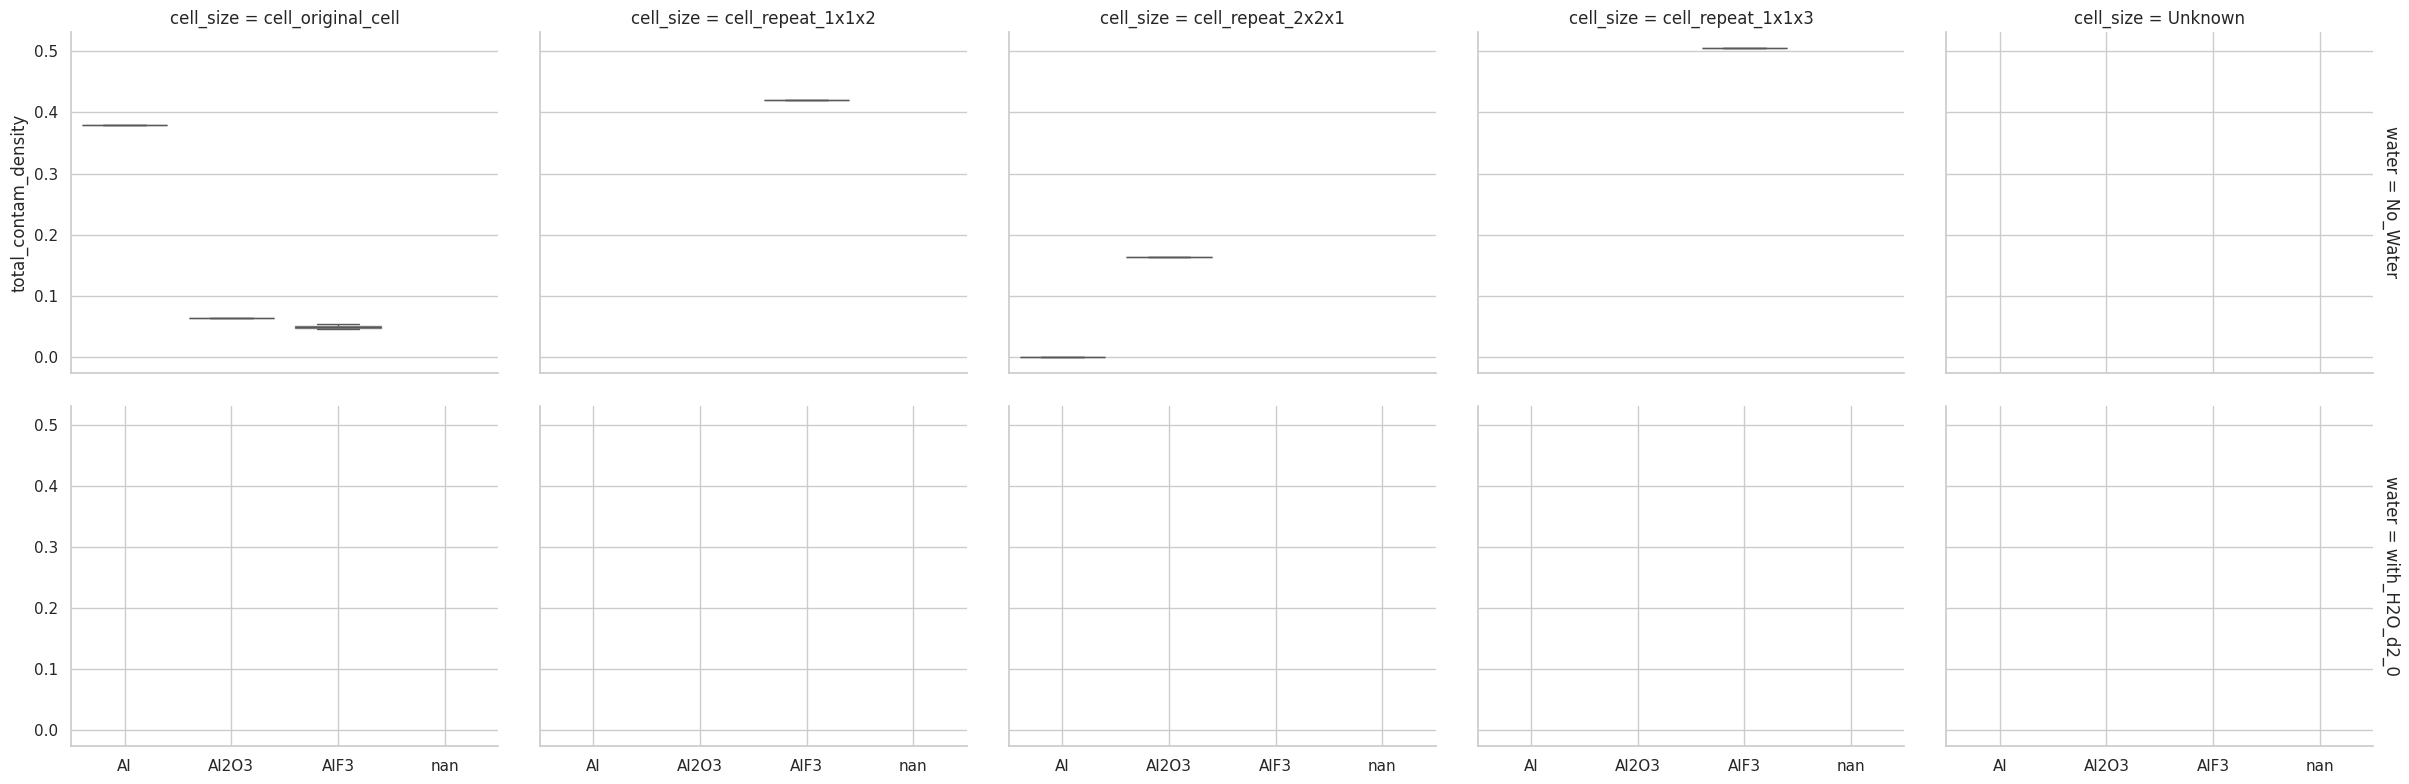

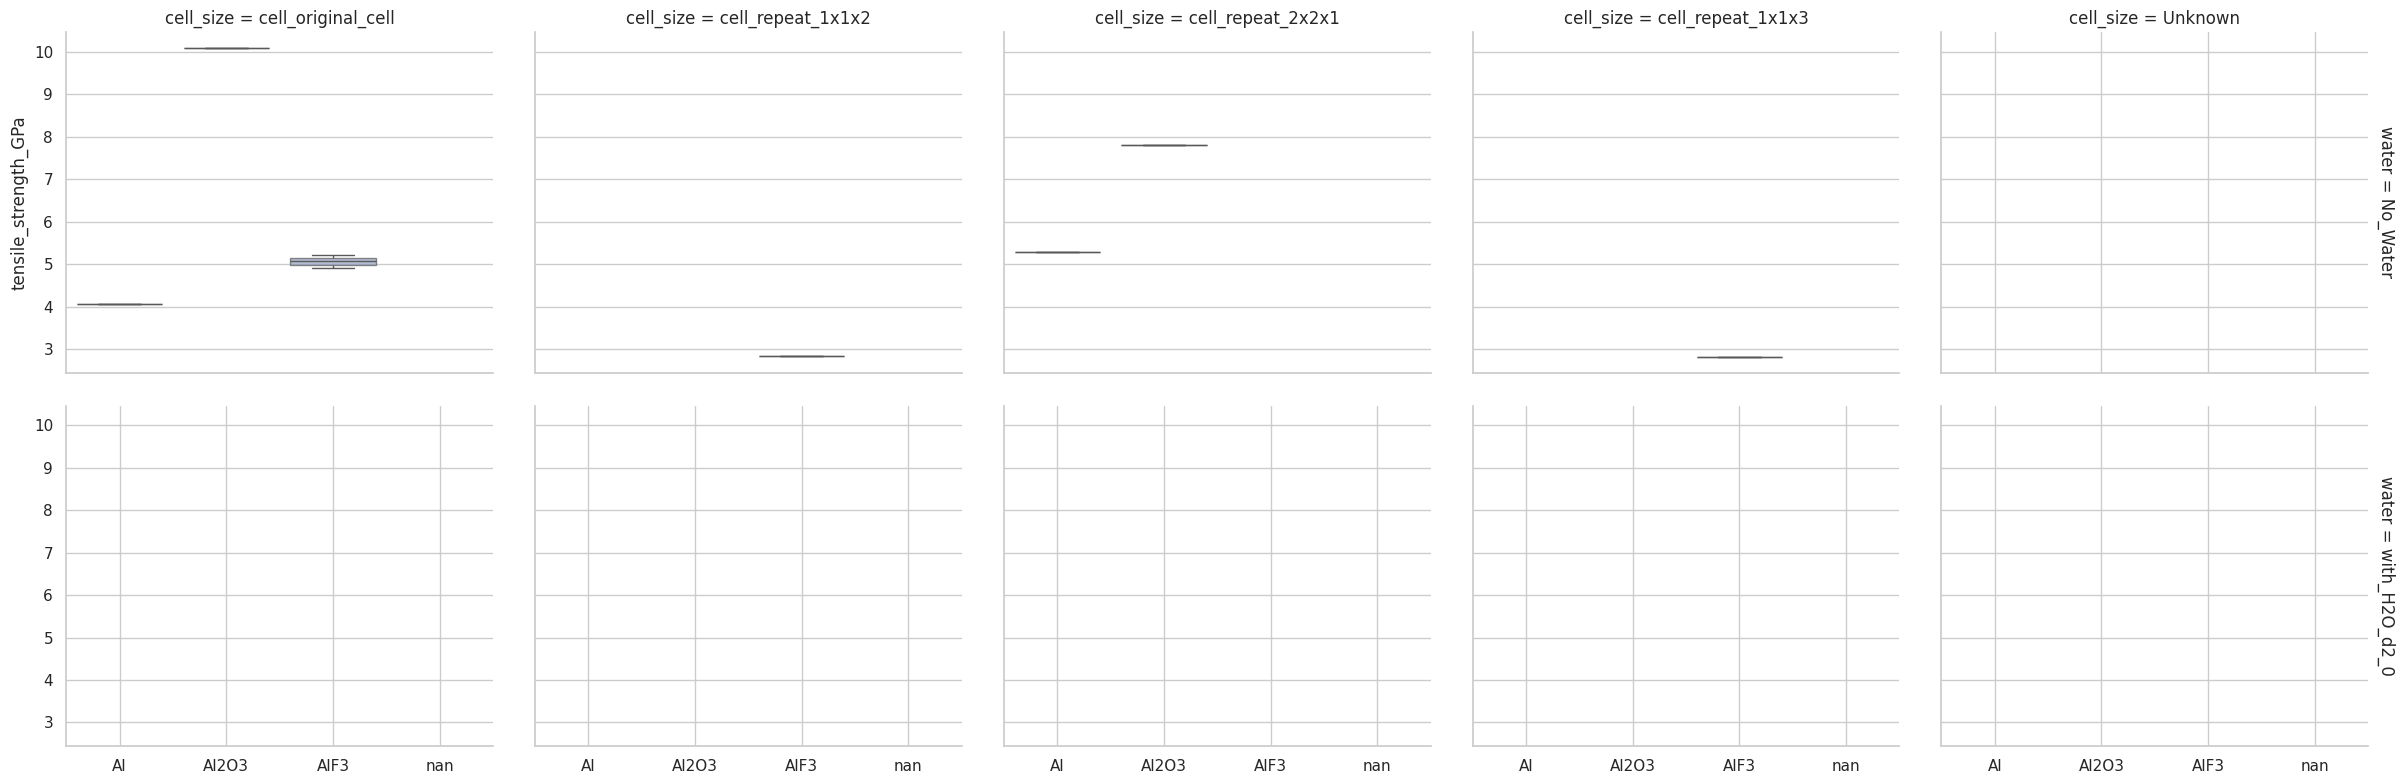

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Set seaborn style
sns.set_theme(style="whitegrid")

# Define file paths
file_path ='/home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/scored_results_for_clean_separation.csv'
output_dir = '/home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/each'


# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# --- 1. データの読み込み ---
try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded {file_path}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    # exit() # Cannot use exit() in this environment
except Exception as e:
    print(f"An error occurred loading {file_path}: {e}")

if 'df' in locals():
    # --- 2. データ前処理 (NaNの補完) ---
    df['cell_size'] = df['cell_size'].fillna('Unknown')
    df['water'] = df['water'].fillna('No_Water')
    
    print("\n--- Data Head after cleaning (First 5 rows) ---")
    print(df[['material', 'cell_size', 'water', 'total_contam_density', 'tensile_strength_GPa']].head())
    
    # 分析対象のカラム
    metric_cols = ['total_contam_density', 'tensile_strength_GPa']
    category_cols = ['material', 'cell_size', 'water']
    
    # --- 3. 組み合わせ集計表 (表) の作成 ---
    print("\n--- Generating Combined Summary Table ---")
    
    try:
        # 3つのカテゴリすべての組み合わせでグループ化し、メトリクスの統計量を計算
        combined_summary = df.groupby(category_cols)[metric_cols].describe()
        
        # 統計量の列レベルを調整 (例: (total_contam_density, mean) -> total_contam_density_mean)
        combined_summary.columns = ['_'.join(col).strip() for col in combined_summary.columns.values]
        
        print(combined_summary)
        
        # CSVファイルとして保存
        output_file_summary = os.path.join(output_dir, "summary_combined_all_conditions.csv")
        combined_summary.to_csv(output_file_summary, encoding='utf-8-sig')
        print(f"Saved combined summary to: {output_file_summary}")
    
    except Exception as e:
        print(f"An error occurred during combined summary generation: {e}")

    # --- 4. 組み合わせ比較図 (図) の作成 (FacetGrid) ---
    print("\n--- Generating Combined Plots (FacetGrid) ---")

    # プロットのパターンを定義 (x軸, 列, 行)
    plot_patterns = [
        ('material', 'cell_size', 'water'),
        ('cell_size', 'material', 'water'),
        ('water', 'material', 'cell_size')
    ]

    for metric in metric_cols:
        for x_val, col_val, row_val in plot_patterns:
            print(f"\nGenerating plot for Y={metric} (X={x_val}, Col={col_val}, Row={row_val})")
            
            try:
                # FacetGridを作成
                g = sns.FacetGrid(df, col=col_val, row=row_val, height=4, aspect=1.2, margin_titles=True, sharey=True)
                
                # X軸のカテゴリ順序を取得 (ソート)
                x_order = sorted(df[x_val].astype(str).unique())

                # ボックスプロットをマッピング
                g.map_dataframe(
                    sns.boxplot, 
                    x=x_val, 
                    y=metric, 
                    palette="Set2", 
                    order=x_order,
                    boxprops=dict(alpha=0.7) # 透明度
                )
                
                # ストリッププロットをマッピング (データ点を重ねる)
                g.map_dataframe(
                    sns.stripplot, 
                    x=x_val, 
                    y=metric, 
                    color=".25", 
                    size=3, 
                    jitter=True,
                    order=x_order
                )
                
                # 軸ラベルとタイトル
                g.set_axis_labels(x_val, metric)
                g.set_titles(col_template=f"{col_val}=" + "{col_name}", row_template=f"{row_val}=" + "{row_name}")
                
                # X軸のラベルを回転 (g.fig.axes をイテレート)
                for ax in g.fig.axes:
                    ax.tick_params(axis='x', rotation=45, labelsize=8) # ラベルが重ならないよう小さくする

                g.fig.suptitle(f'{metric} (X={x_val}, Col={col_val}, Row={row_val})', y=1.05)
                g.tight_layout(rect=[0, 0, 1, 0.98]) # タイトルとの重複を防ぐ
                
                # ファイルに保存
                plot_file = os.path.join(output_dir, f"plot_combo_Y_{metric}_X_{x_val}_Col_{col_val}.png")
                g.savefig(plot_file)
                print(f"Saved plot: {plot_file}")
                plt.close(g.fig) # メモリ解放のために図を閉じる
            
            except Exception as e:
                print(f"An error occurred during plotting (Y={metric}, X={x_val}): {e}")

    print("\nAnalysis complete.")
    
    # Let's list the generated files
    print(f"\n--- Generated Files in {output_dir} ---")
    generated_files = os.listdir(output_dir)
    print(generated_files)

else:
    print("DataFrame 'df' not loaded. Cannot proceed with analysis.")

Loading data from '/home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/scored_results_for_clean_separation.csv'...

--- Processed Data (10 items) ---
| x_label                |   tensile_strength_GPa |   total_contam_density |
|:-----------------------|-----------------------:|-----------------------:|
| Al | 2x2x1 | Dry       |                  5.280 |                  0.000 |
| Al | 2x2x1 | H2O       |                  4.785 |                  0.154 |
| Al | Original | Dry    |                  4.074 |                  0.379 |
| Al2O3 | 2x2x1 | Dry    |                  7.801 |                  0.163 |
| Al2O3 | 2x2x1 | H2O    |                  8.369 |                  0.160 |
| Al2O3 | Original | Dry |                 10.094 |                  0.063 |
| AlF3 | 1x1x2 | Dry     |                  2.851 |                  0.420 |
| AlF3 | 1x1x3 | Dry     |                  2.815 |                  0.506 |
| AlF3 | 2x2x1 | H2O     |                  5.963 |                  0.164 |
| 

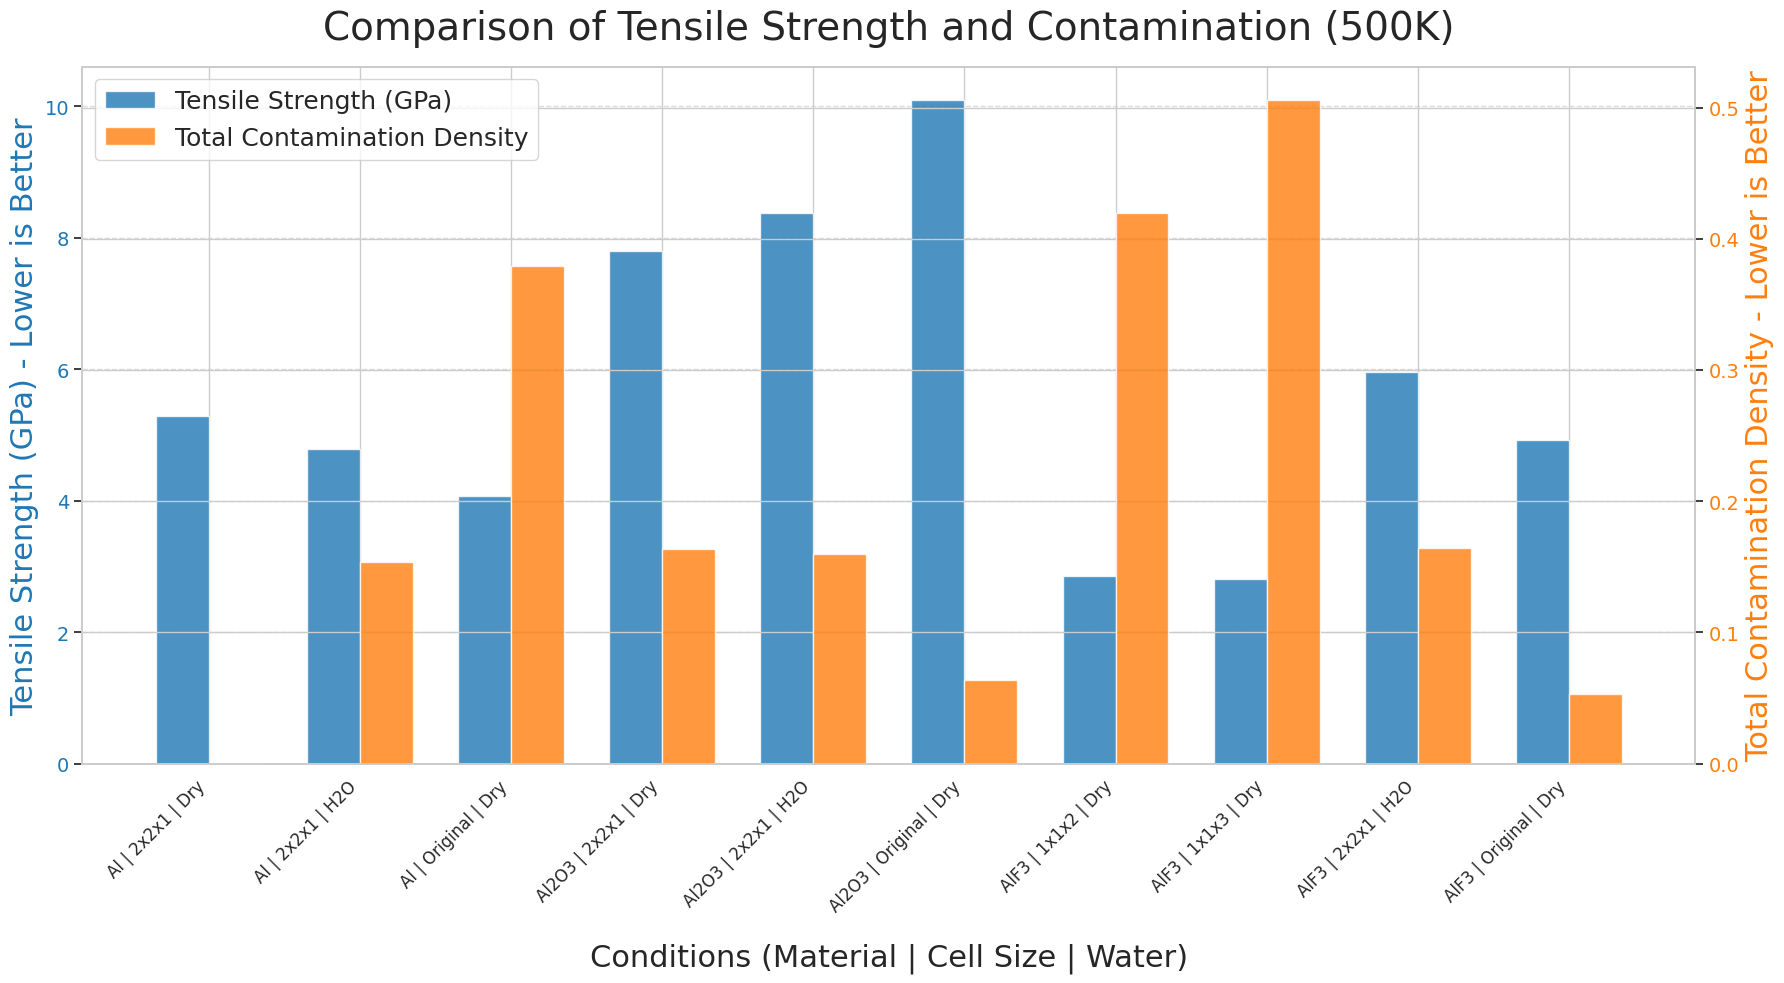

In [47]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# --- Settings ---

# (★) Path to the CSV file to read
CSV_FILE_PATH = '/home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/scored_results_for_clean_separation.csv'

# (★) Filename for the saved graph
OUTPUT_GRAPH_PATH = 'material_comparison_chart_500K_EN.png'

# --- 1. Data Loading and Preprocessing ---

def load_and_preprocess_data(csv_path):
    """
    Load CSV, filter data, and format labels for the graph.
    """
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"Error: File not found at '{csv_path}'")
        sys.exit() # Use sys.exit()

    # 1. (★) Filter for 500K data only
    df_filtered = df[df['high_temp_K'] == 500].copy()
    
    if df_filtered.empty:
        print("Error: No data found for 500K.")
        return None

    # 2. (★) Format 'cell_size' labels
    df_filtered['cell_size_label'] = df_filtered['cell_size'].str.replace('cell_repeat_', '', regex=False)
    df_filtered['cell_size_label'] = df_filtered['cell_size_label'].str.replace('cell_original_cell', 'Original', regex=False)
    
    # 3. (★) Format 'water' labels
    df_filtered['water_label'] = df_filtered['water'].apply(
        lambda x: 'H2O' if pd.notna(x) and 'with_H2O' in str(x) else 'Dry'
    )
    
    # 4. (★) Create the composite X-axis label
    df_filtered['x_label'] = (
        df_filtered['material'] + ' | ' +
        df_filtered['cell_size_label'] + ' | ' +
        df_filtered['water_label']
    )
    
    # 5. (★) Sort values for a clean graph
    df_filtered = df_filtered.sort_values(by=['material', 'cell_size_label', 'water_label'])
    
    return df_filtered

# --- 2. Graph Creation ---

def create_comparison_chart(df, output_path):
    """
    Create and save a dual-axis bar chart for Tensile Strength and Contamination Density.
    """
    if df is None or df.empty:
        print("No data available to create chart.")
        return

    # --- Font Size Configuration ---
    TITLE_FONTSIZE = 28
    AXIS_LABEL_FONTSIZE = 22
    TICK_LABEL_FONTSIZE = 14
    LEGEND_FONTSIZE = 18
    XTICK_FONTSIZE = 12

    # X-axis setup
    x_labels = df['x_label']
    x_pos = np.arange(len(x_labels))
    bar_width = 0.35  # Bar width

    # Chart setup
    fig, ax1 = plt.subplots(figsize=(18, 10)) # Increased figure size
    
    # --- Y1 Axis (Left): Tensile Strength (Blue) ---
    color1 = 'tab:blue'
    ax1.set_xlabel('Conditions (Material | Cell Size | Water)', fontsize=AXIS_LABEL_FONTSIZE, labelpad=20)
    ax1.set_ylabel('Tensile Strength (GPa)', color=color1, fontsize=AXIS_LABEL_FONTSIZE)
    bar1 = ax1.bar(x_pos - bar_width/2, df['tensile_strength_GPa'], bar_width, 
                   label='Tensile Strength (GPa)', color=color1, alpha=0.8)
    ax1.tick_params(axis='y', labelcolor=color1, labelsize=TICK_LABEL_FONTSIZE)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # --- Y2 Axis (Right): Contamination Density (Orange) ---
    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.set_ylabel('Total Contamination Density', color=color2, fontsize=AXIS_LABEL_FONTSIZE)
    bar2 = ax2.bar(x_pos + bar_width/2, df['total_contam_density'], bar_width, 
                   label='Total Contamination Density', color=color2, alpha=0.8)
    ax2.tick_params(axis='y', labelcolor=color2, labelsize=TICK_LABEL_FONTSIZE)

    # --- X-Axis Labels ---
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=XTICK_FONTSIZE)

    # --- Title and Legend ---
    plt.title('Comparison of Tensile Strength and Contamination (500K)', fontsize=TITLE_FONTSIZE, pad=20)
    
    # Combine legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=LEGEND_FONTSIZE)

    fig.tight_layout()  # Adjust layout
    
    # --- Save Graph ---
    try:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\nGraph successfully saved to: '{output_path}'")
    except Exception as e:
        print(f"Error saving graph: {e}")

# --- 3. Main Execution ---
def main():
    print(f"Loading data from '{CSV_FILE_PATH}'...")
    processed_data = load_and_preprocess_data(CSV_FILE_PATH)
    
    if processed_data is not None:
        print(f"\n--- Processed Data ({len(processed_data)} items) ---")
        print(processed_data[['x_label', 'tensile_strength_GPa', 'total_contam_density']].to_markdown(index=False, floatfmt=".3f"))
        
        print("\nCreating graph...")
        create_comparison_chart(processed_data, OUTPUT_GRAPH_PATH)

if __name__ == "__main__":
    main()

In [53]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# --- 1. General Settings ---

# (★) Path to the CSV file to read
CSV_FILE_PATH =  '/home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/scored_results_for_clean_separation.csv'

# (★) Directory to save the output graphs
OUTPUT_DIR = 'presentation_graphs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# (★) Font Size Configuration (Centralized)
FONT_SIZES = {
    'TITLE': 26,
    'AXIS_LABEL': 20,
    'TICK_LABEL': 14,
    'LEGEND': 16,
    'XTICK_LABEL': 14
}

# (★) Color Palette Configuration (Centralized)
COLOR_PALETTE = {
    'strength': 'tab:blue',
    'contamination': 'tab:orange',
    'materials': {
        'Al': '#005088',
        'Al2O3': '#e63946',
        'AlF3': '#11caa0',
    }
}


# --- 2. Data Loading and Preprocessing ---

def load_and_preprocess_data(csv_path):
    """
    Load CSV, filter data, and format labels for the graph.
    """
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"Error: File not found at '{csv_path}'")
        sys.exit()

    # Create formatted labels for comparison
    
    # 1. Format 'cell_size'
    df['cell_size_label'] = df['cell_size'].str.replace('cell_repeat_', '', regex=False)
    df['cell_size_label'] = df['cell_size_label'].str.replace('cell_original_cell', 'Original', regex=False)
    
    # 2. Format 'water'
    df['water_label'] = df['water'].apply(
        lambda x: 'H2O' if pd.notna(x) and 'with_H2O' in str(x) else 'Dry'
    )
    
    # 3. Format 'high_temp_K'
    df['temp_label'] = df['high_temp_K'].astype(str) + 'K'
    
    # 4. Sort values for consistency
    df = df.sort_values(by=['material', 'cell_size_label', 'water_label', 'high_temp_K'])
    
    return df

# --- 3. Graph Creation (Individual Plots) ---

def plot_dual_axis_comparison(df_plot, x_col, title, filename):
    """
    Generic function to create and save a dual-axis bar chart.
    """
    if df_plot.empty or len(df_plot) < 2:
        print(f"Skipping plot '{title}': Not enough data to compare.")
        return

    x_labels = df_plot[x_col]
    x_pos = np.arange(len(x_labels))
    bar_width = 0.35

    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # --- Y1 Axis (Left): Tensile Strength (Blue) ---
    color1 = COLOR_PALETTE['strength']
    ax1.set_xlabel(title.split(' vs ')[0], fontsize=FONT_SIZES['AXIS_LABEL'], labelpad=15)
    ax1.set_ylabel('Tensile Strength (GPa)', color=color1, fontsize=FONT_SIZES['AXIS_LABEL'])
    bar1 = ax1.bar(x_pos - bar_width/2, df_plot['tensile_strength_GPa'], bar_width, 
                   label='Tensile Strength (GPa)', color=color1, alpha=0.8)
    ax1.tick_params(axis='y', labelcolor=color1, labelsize=FONT_SIZES['TICK_LABEL'])
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # --- Y2 Axis (Right): Contamination Density (Orange) ---
    ax2 = ax1.twinx()
    color2 = COLOR_PALETTE['contamination']
    ax2.set_ylabel('Total Contamination Density', color=color2, fontsize=FONT_SIZES['AXIS_LABEL'])
    bar2 = ax2.bar(x_pos + bar_width/2, df_plot['total_contam_density'], bar_width, 
                   label='Total Contamination Density', color=color2, alpha=0.8)
    ax2.tick_params(axis='y', labelcolor=color2, labelsize=FONT_SIZES['TICK_LABEL'])

    # --- X-Axis Labels ---
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels, rotation=0, ha='center', fontsize=FONT_SIZES['XTICK_LABEL'])

    # --- Title and Legend ---
    subtitle = f"Conditions: {df_plot['subtitle'].iloc[0]}"
    plt.title(f"{title}\n({subtitle})", fontsize=FONT_SIZES['TITLE'], pad=20)
    
    # (★削除) 凡例（はんれい）の描画コードを削除
    # lines, labels = ax1.get_legend_handles_labels()
    # lines2, labels2 = ax2.get_legend_handles_labels()
    # ax2.legend(lines + lines2, labels + labels2, loc='upper center', 
    #            bbox_to_anchor=(0.5, 1.15), ncol=2, fontsize=FONT_SIZES['LEGEND'])

    fig.tight_layout(rect=[0, 0, 1, 0.95]) # (★変更) 凡例スペースが不要になったため、タイトルのマージンを調整
    
    # --- Save Graph ---
    try:
        output_path = os.path.join(OUTPUT_DIR, filename)
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"Graph successfully saved to: '{output_path}'")
        plt.close(fig)
    except Exception as e:
        print(f"Error saving graph '{filename}': {e}")

def create_comparison_charts(df):
    """
    Finds comparable data groups and generates individual plots.
    """
    if df is None or df.empty:
        print("No data available to create charts.")
        return

    # --- 1. Plot Material Comparison (Fixed Cell, Water, Temp) ---
    group_cols_material = ['cell_size_label', 'water_label', 'temp_label']
    grouped = df.groupby(group_cols_material)
    
    plot_count = 0
    for name, group in grouped:
        if group['material'].nunique() > 1: # Find groups with more than one material
            group = group.sort_values(by='material')
            subtitle = f"Cell: {name[0]}, Water: {name[1]}, Temp: {name[2]}"
            group['subtitle'] = subtitle
            plot_dual_axis_comparison(
                group, 
                x_col='material', 
                title='Material Comparison', 
                filename=f'chart_01_material_comp_{plot_count}.png'
            )
            plot_count += 1

    # --- 2. Plot Cell Size Comparison (Fixed Material, Water, Temp) ---
    group_cols_cell = ['material', 'water_label', 'temp_label']
    grouped = df.groupby(group_cols_cell)
    
    plot_count = 0
    for name, group in grouped:
        if group['cell_size_label'].nunique() > 1:
            group = group.sort_values(by='cell_size_label')
            subtitle = f"Material: {name[0]}, Water: {name[1]}, Temp: {name[2]}"
            group['subtitle'] = subtitle
            plot_dual_axis_comparison(
                group, 
                x_col='cell_size_label', 
                title='Cell Size Comparison', 
                filename=f'chart_02_cell_size_comp_{plot_count}.png'
            )
            plot_count += 1

    # --- 3. Plot Water Comparison (Fixed Material, Cell, Temp) ---
    group_cols_water = ['material', 'cell_size_label', 'temp_label']
    grouped = df.groupby(group_cols_water)
    
    plot_count = 0
    for name, group in grouped:
        if group['water_label'].nunique() > 1:
            group = group.sort_values(by='water_label')
            subtitle = f"Material: {name[0]}, Cell: {name[1]}, Temp: {name[2]}"
            group['subtitle'] = subtitle
            plot_dual_axis_comparison(
                group, 
                x_col='water_label', 
                title='Water (H2O) Comparison', 
                filename=f'chart_03_water_comp_{plot_count}.png'
            )
            plot_count += 1

    # --- 4. Plot Temperature Comparison (Fixed Material, Cell, Water) ---
    group_cols_temp = ['material', 'cell_size_label', 'water_label']
    grouped = df.groupby(group_cols_temp)
    
    plot_count = 0
    for name, group in grouped:
        if group['temp_label'].nunique() > 1:
            group = group.sort_values(by='high_temp_K')
            subtitle = f"Material: {name[0]}, Cell: {name[1]}, Water: {name[2]}"
            group['subtitle'] = subtitle
            plot_dual_axis_comparison(
                group, 
                x_col='temp_label', 
                title='Temperature Comparison', 
                filename=f'chart_04_temp_comp_{plot_count}.png'
            )
            plot_count += 1

# --- 4. Main Execution ---
def main():
    print(f"Loading data from '{CSV_FILE_PATH}'...")
    processed_data = load_and_preprocess_data(CSV_FILE_PATH)
    
    if processed_data is not None:
        print(f"\n--- Data preprocessing complete ({len(processed_data)} items) ---")
        
        print("\nCreating comparison charts...")
        create_comparison_charts(processed_data)
        
        print("\nAll graph generation tasks complete.")
        print(f"Check the '{OUTPUT_DIR}' directory for the .png files.")

if __name__ == "__main__":
    main()

Loading data from '/home/jovyan/Kaori/MD/LiB_2/structure/MD_PVDF/output/scored_results_for_clean_separation.csv'...

--- Data preprocessing complete (12 items) ---

Creating comparison charts...
Graph successfully saved to: 'presentation_graphs/chart_01_material_comp_0.png'
Graph successfully saved to: 'presentation_graphs/chart_01_material_comp_1.png'
Graph successfully saved to: 'presentation_graphs/chart_01_material_comp_2.png'
Graph successfully saved to: 'presentation_graphs/chart_02_cell_size_comp_0.png'
Graph successfully saved to: 'presentation_graphs/chart_02_cell_size_comp_1.png'
Graph successfully saved to: 'presentation_graphs/chart_02_cell_size_comp_2.png'
Graph successfully saved to: 'presentation_graphs/chart_03_water_comp_0.png'
Graph successfully saved to: 'presentation_graphs/chart_03_water_comp_1.png'
Graph successfully saved to: 'presentation_graphs/chart_04_temp_comp_0.png'

All graph generation tasks complete.
Check the 'presentation_graphs' directory for the .png